In [25]:
%load_ext autoreload
%autoreload 2
import json
import csv
import os
import itertools

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shap

import numpy as np
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler, TensorDataset
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    f1_score,
    balanced_accuracy_score,
    classification_report
)


from xgboost import XGBClassifier

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
df = pd.read_csv('self_report/007.csv')
#(df['Timestamp']).astype('datetime64[us]')-np.timedelta64(4, 'h')
#pd.to_datetime(df['Timestamp'], unit='us')
pd.to_datetime(df['timestamp'])

In [11]:
""" This code extracts each biomedical signal from the .csv file as a pandas dataframe,
and samples 3-second time windows to apply band-pass filter, ICA, and FFT to extract features from the window
"""

' This code extracts each biomedical signal from the .csv file as a pandas dataframe,\nand samples 3-second time windows to apply band-pass filter, ICA, and FFT to extract features from the window\n'

In [12]:
"""This is the pytorch dataset object that extracts
"""

'This is the pytorch dataset object that extracts\n'

In [24]:
from src.dataset_c import BiomedicalPainDataset

In [ ]:
# Load data
subject=p=2
signals_df = pd.read_csv(f'processed_signals/00{p}.csv')#[-16200:]
#signals_df.drop(columns=['accelerometer_x',	'accelerometer_y', 'accelerometer_z', 'gyroscope_x', 'gyroscope_y',	'gyroscope_z'], inplace=True)
pain_df = pd.read_csv(f'self_report/00{p}.csv')
# Hyper-parameters

window_duration=1.0
step_size=1.0

In [ ]:
"""
All experiment cases:
    - Single subject cross-validation
        - Leave one mode out (LOMO) cross-validation
        - Stratified cross-validation
    - Leave one subject out (LOSO) cross-validation

    - All subjects cross-validation
"""

In [ ]:
""" all_data_df = pd.DataFrame()
for p in range(1, 8):
    # Load signals and self-report data
    signals_df = pd.read_csv(f'processed_signals/00{p}.csv')
    signals_df['subject'] = p
    # Merge all self-report data
    all_data_df = pd.concat([all_data_df, signals_df], axis=0, ignore_index=True)
    
all_data_df.to_csv(f'processed_signals/all.csv', index=False) """

In [ ]:
# with SHAP
def window_filter(df):
    # filter windows from one single subject and one mode
    return df['subject'].nunique() == 1 and df['Mode'].nunique() == 1

# Load data
subject=p=2
signals_df = pd.read_csv(f'processed_signals/00{p}.csv')#[-16200:]
#signals_df.drop(columns=['accelerometer_x',	'accelerometer_y', 'accelerometer_z', 'gyroscope_x', 'gyroscope_y',	'gyroscope_z'], inplace=True)
pain_df = pd.read_csv(f'self_report/00{p}.csv')
# Hyper-parameters

window_duration=1.0
step_size=1.0
tonic_cutoff_freq = 0.05  # 20 Hz

# 1) Instantiate and split your sliding-window pain dataset by 'Mode' groups
ds = BiomedicalPainDataset(
    signals_df=signals_df,
    pain_df=pain_df,
    timestamp_col='timestamp',
    window_duration=window_duration,
    step_size=step_size,
    signal_columns=['eda','bvp','temperature'],
    window_filter=window_filter,  # filter windows by subject and mode
    bandpass_freqs=(0.5,40),
    freq_bands=[(0.5,4),(4,8),(8,12),(12,30),(30,60)],
    resample_freq=100,
    include_tonic_phasic=True,
    tonic_cutoff=tonic_cutoff_freq,
)

train_ds, test_ds = ds.split(test_size=0.2, split_by=['Mode']) # type: ignore
#train_ds, test_ds = ds.split(test_size=0.2, stratify_by=['Mode']) # type: ignore
train_ds.apply_scaling('standard', fit=True)
test_ds.apply_scaling('standard', fit=False, scaler=train_ds.scaler)  # uses train_ds.scaler

train_ds.process_nan('interpolate', 'linear')

# 2) Helper to convert any BaseSlidingWindowDataset into X, Y NumPy arrays
def dataset_to_numpy(dataset: torch.utils.data.Dataset):
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    X_parts, Y_parts = [], []
    for Xb, Yb in loader:
        X_parts.append(Xb)
        Y_parts.append(Yb)
    X = torch.cat(X_parts, dim=0).numpy()
    Y = torch.cat(Y_parts, dim=0).flatten().numpy()
    return X, Y

X_train, y_train = dataset_to_numpy(train_ds)
X_test,  y_test  = dataset_to_numpy(test_ds)

# 3) (Optional) Balance your training set with a WeightedRandomSampler
class_counts = np.bincount(y_train.astype(int))
class_weights = 1.0 / class_counts
sample_weights = class_weights[y_train.astype(int)]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(y_train), replacement=False) # type: ignore

# Wrap balanced train set into a single batch
train_loader = DataLoader(
    TensorDataset(torch.tensor(X_train), torch.tensor(y_train)),
    sampler=sampler,
    batch_size=len(y_train)
)
X_train_bal, y_train_bal = next(iter(train_loader))
X_train_bal = X_train_bal.numpy();  y_train_bal = y_train_bal.numpy()

# 4) Define your modeling pipelines
def make_pipeline(estimator):
    return Pipeline([
        ('impute', SimpleImputer(strategy='mean')),
        ('scale',  StandardScaler()),
        ('clf',    estimator)
    ])

models = {
    #'SVM':               make_pipeline(SVC(kernel='rbf', probability=True, random_state=42)),
    'RandomForest':      make_pipeline(RandomForestClassifier(n_estimators=100, random_state=42)),
    #'GradientBoosting':  make_pipeline(GradientBoostingClassifier(random_state=42)),
    'KNeighbors':        make_pipeline(KNeighborsClassifier(n_neighbors=5)),
    'LogisticRegression':make_pipeline(LogisticRegression(max_iter=1000, random_state=42)),
    'XGBoost':           make_pipeline(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)),
    #'MLP':         make_pipeline(MLPClassifier(hidden_layer_sizes=(256,256,256,256), learning_rate='adaptive', max_iter=500, random_state=42)),
        # requires tensorflow
    'NaiveBayes':        make_pipeline(GaussianNB()),
}

# --- 0) Optionally subsample for SHAP speed ---
# we'll take 1000 train and 500 test samples at random
rng = np.random.RandomState(42)
idx_train = rng.choice(len(X_train_bal), size=min(200, len(X_train_bal)), replace=False)
idx_test  = rng.choice(len(X_test),      size=min(100,  len(X_test)),      replace=False)
X_train_sub, y_train_sub = X_train_bal[idx_train], y_train_bal[idx_train]
X_test_sub,  y_test_sub  = X_test[idx_test],    y_test[idx_test]

#feature_names = [f"f{i}" for i in range(X_train.shape[1])]  # replace with real names if available
feature_names = ds._generate_feature_names()  # use dataset's feature names

# 5) Train & evaluate
for name, pipe in models.items():
    pipe.fit(X_train_bal, y_train_bal)
    y_pred = pipe.predict(X_test)
    print(f"\n=== {name} ===")
    
    print("F1 (macro):",            f1_score( y_test, y_pred, average='macro' ))
    print("Balanced Accuracy:",     balanced_accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred, digits=3))
    
    # Choose appropriate explainer
    clf = pipe.named_steps['clf']
    transformer = Pipeline(pipe.steps[:-1])  # imputer+scaler
    X_train_trans = transformer.transform(X_train_sub)
    X_test_trans  = transformer.transform(X_test_sub)
    
    if name in ('RandomForest','GradientBoosting','XGBoost'):
        explainer = shap.TreeExplainer(clf, data=X_train_trans)
    elif name in ('MLP'):
        explainer = shap.DeepExplainer(clf, X_train_trans[:100])  # MLP needs a small background set
    else:
        # Kernel explainer on small background
        explainer = shap.KernelExplainer(clf.predict_proba, X_train_trans[:100])
        
    # Compute SHAP values for class 1 (or mean over classes)
    shap_values = explainer.shap_values(X_test_trans)
    # shap_values is list of arrays if multiclass
    if isinstance(shap_values, list):
        # take class 1 explanations
        sv = shap_values[1]
    else:
        sv = shap_values
        
    # Mean absolute importance per feature
    # If sv is 2D, mean over samples only
    if sv.ndim == 2:
        mean_abs = np.abs(sv).mean(axis=0)
    elif sv.ndim == 3:
        mean_abs = np.abs(sv).mean(axis=(0, 2))
    ranked_ix = np.argsort(-mean_abs) # type: ignore
    print("Top features by mean(|SHAP|):")
    for i in ranked_ix[:15]:
        print(f"  {feature_names[i]:<15} : {mean_abs[i]:.4f}") # type: ignore

    # Optional: summary plot
    """ shap.summary_plot(sv, X_test_trans, feature_names=feature_names, show=False)
    plt.title(f"SHAP summary for {name}")
    plt.tight_layout()
    plt.show() """


In [37]:
# with SHAP and loop through all combinations of hyper-parameters

# Build master results DataFrame
results = pd.DataFrame()
# window filter
def window_filter(df):
    # filter windows from one single subject and one mode
    return df['Mode'].nunique() == 1# and df['subject'].nunique() == 1

SUBJECTS = [2, 3, 4, 5, 6, 7, 1]
TONIC_CUTOFFS = [0.05, 0.1, 0.25] 
WINDOW_DURATIONS = [0.5, 1.0, 5.0]  # seconds
WINDOW_STEPS = [0.5, 1.0, 5.0]  # seconds
SPLIT_METHODS = ['split', 'stratify']   # 

# loop through all combinations of hyper-parameters
for p, tonic_cutoff, window_duration, step_size, split_method in itertools.product(
        SUBJECTS,
        TONIC_CUTOFFS,
        WINDOW_DURATIONS,
        WINDOW_STEPS,
        SPLIT_METHODS,
):
    params = {
        'subject': p,
        'tonic_cutoff': tonic_cutoff,
        'window_duration': window_duration,
        'step_size': step_size,
        'split_method': split_method
    }
    print(f"\nRunning for params: {params}")
    # Load data
    subject=p
    signals_df = pd.read_csv(f'processed_signals/00{p}.csv')
    #signals_df.drop(columns=['accelerometer_x',	'accelerometer_y', 'accelerometer_z', 'gyroscope_x', 'gyroscope_y',	'gyroscope_z'], inplace=True)
    pain_df = pd.read_csv(f'self_report/00{p}.csv')


    # 1) Instantiate and split your sliding-window pain dataset by 'Mode' groups
    ds = BiomedicalPainDataset(
        signals_df=signals_df,
        pain_df=pain_df,
        timestamp_col='timestamp',
        window_duration=window_duration,
        step_size=step_size,
        signal_columns=['eda','bvp','temperature'],
        window_filter=window_filter,  # filter windows by subject and mode
        bandpass_freqs=(0.5, 45),  # 45 < 50 (Nyquist for 100Hz)
        freq_bands=[(0.5,4),(4,8),(8,12),(12,30),(30,45)],  # also update freq_bands to not exceed 45Hz
        resample_freq=100,
        include_tonic_phasic=True,
        tonic_cutoff=tonic_cutoff,
    )

    if split_method == 'split':
        train_ds, test_ds = ds.split(test_size=0.2, split_by=['Mode']) # type: ignore
    elif split_method == 'stratify':
        train_ds, test_ds = ds.split(test_size=0.2, stratify_by=['Mode']) # type: ignore
    train_ds.apply_scaling('standard', fit=True)
    test_ds.apply_scaling('standard', fit=False, scaler=train_ds.scaler)  # uses train_ds.scaler

    train_ds.process_nan('interpolate', 'linear')

    # 2) Helper to convert any BaseSlidingWindowDataset into X, Y NumPy arrays
    def dataset_to_numpy(dataset: torch.utils.data.Dataset):
        loader = DataLoader(dataset, batch_size=64, shuffle=False)
        X_parts, Y_parts = [], []
        for Xb, Yb in loader:
            X_parts.append(Xb)
            Y_parts.append(Yb)
        X = torch.cat(X_parts, dim=0).numpy()
        Y = torch.cat(Y_parts, dim=0).flatten().numpy()
        return X, Y

    X_train, y_train = dataset_to_numpy(train_ds)
    X_test,  y_test  = dataset_to_numpy(test_ds)

    # 3) (Optional) Balance your training set with a WeightedRandomSampler
    class_counts = np.bincount(y_train.astype(int))
    class_weights = 1.0 / class_counts
    sample_weights = class_weights[y_train.astype(int)]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(y_train), replacement=False) # type: ignore

    # Wrap balanced train set into a single batch
    train_loader = DataLoader(
        TensorDataset(torch.tensor(X_train), torch.tensor(y_train)),
        sampler=sampler,
        batch_size=len(y_train)
    )
    X_train_bal, y_train_bal = next(iter(train_loader))
    X_train_bal = X_train_bal.numpy();  y_train_bal = y_train_bal.numpy()

    # 4) Define your modeling pipelines
    def make_pipeline(estimator):
        return Pipeline([
            ('impute', SimpleImputer(strategy='mean')),
            ('scale',  StandardScaler()),
            ('clf',    estimator)
        ])

    models = {
        #'SVM':               make_pipeline(SVC(kernel='rbf', probability=True, random_state=42)),
        'RandomForest':      make_pipeline(RandomForestClassifier(n_estimators=100, random_state=42)),
        #'GradientBoosting':  make_pipeline(GradientBoostingClassifier(random_state=42)),
        'KNeighbors':        make_pipeline(KNeighborsClassifier(n_neighbors=5)),
        'LogisticRegression':make_pipeline(LogisticRegression(max_iter=1000, random_state=42)),
        'XGBoost':           make_pipeline(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)),
        #'MLP':         make_pipeline(MLPClassifier(hidden_layer_sizes=(256,256,256,256), learning_rate='adaptive', max_iter=500, random_state=42)),
            # requires tensorflow
        'NaiveBayes':        make_pipeline(GaussianNB()),
    }

    # --- 0) Optionally subsample for SHAP speed ---
    # we'll take 1000 train and 500 test samples at random
    rng = np.random.RandomState(42)
    idx_train = rng.choice(len(X_train_bal), size=min(200, len(X_train_bal)), replace=False)
    idx_test  = rng.choice(len(X_test),      size=min(100,  len(X_test)),      replace=False)
    X_train_sub, y_train_sub = X_train_bal[idx_train], y_train_bal[idx_train]
    X_test_sub,  y_test_sub  = X_test[idx_test],    y_test[idx_test]

    #feature_names = [f"f{i}" for i in range(X_train.shape[1])]  # replace with real names if available
    feature_names = ds._generate_feature_names()  # use dataset's feature names

    # 5) Train & evaluate
    for name, pipe in models.items():
        pipe.fit(X_train_bal, y_train_bal)
        y_pred = pipe.predict(X_test)
        print(f"\n=== {name} ===")
        f1 = f1_score( y_test, y_pred, average='macro' )
        bal_acc = balanced_accuracy_score(y_test, y_pred)

        print("F1 (macro):",            f1)
        print("Balanced Accuracy:",     bal_acc)
        #print("Classification Report:\n", classification_report(y_test, y_pred, digits=3))
        
        # Choose appropriate explainer
        clf = pipe.named_steps['clf']
        transformer = Pipeline(pipe.steps[:-1])  # imputer+scaler
        X_train_trans = transformer.transform(X_train_sub)
        X_test_trans  = transformer.transform(X_test_sub)
        
        if name in ('RandomForest','GradientBoosting','XGBoost'):
            explainer = shap.TreeExplainer(clf, data=X_train_trans)
            # Compute SHAP values for class 1 (or mean over classes)
            shap_values = explainer.shap_values(X_test_trans, check_additivity=False)
        elif name in ('MLP'):
            explainer = shap.DeepExplainer(clf, X_train_trans[:100])  # MLP needs a small background set
            shap_values = explainer.shap_values(X_test_trans)
        else:
            # Kernel explainer on small background
            explainer = shap.KernelExplainer(clf.predict_proba, X_train_trans[:100])
            shap_values = explainer.shap_values(X_test_trans)
        # shap_values is list of arrays if multiclass
        if isinstance(shap_values, list):
            # take class 1 explanations
            sv = shap_values[1]
        else:
            sv = shap_values
            
        # Mean absolute importance per feature
        # If sv is 2D, mean over samples only
        if sv.ndim == 2:
            mean_abs = np.abs(sv).mean(axis=0)
        elif sv.ndim == 3:
            mean_abs = np.abs(sv).mean(axis=(0, 2))
        ranked_ix = np.argsort(-mean_abs) # type: ignore
        print("Top features by mean(|SHAP|):")
        top_k = 3
        for i in ranked_ix[:top_k]:
            print(f"  {feature_names[i]:<25} : {mean_abs[i]:.4f}") # type: ignore

        top_k = 15
        top_idx   = ranked_ix[:]                      # indices of top K
        top_feats = [feature_names[i] for i in top_idx]    # their names
        top_vals  = [mean_abs[i] for i in top_idx]         # their SHAP importances
        
        # Record a row
        row = {**params,
            'model': name,
            'f1_macro': f1,
            'balanced_acc': bal_acc,
            'top_shap_feats':  top_feats,
            'top_shap_vals':   top_vals,
            }
        results = pd.concat([results, pd.DataFrame([row])], ignore_index=True)

        # Persist after each run
        results.to_csv('experiments.csv', index=False)
        results.to_feather('experiments.feather')

        print(f"Finished {name} {params} → F1={f1:.3f}, BalAcc={bal_acc:.3f}")



Running for params: {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 0.5, 'step_size': 0.5, 'split_method': 'split'}

=== RandomForest ===
F1 (macro): 0.2308968827689566
Balanced Accuracy: 0.45598082584582106
Top features by mean(|SHAP|):
  temperature_tonic_var     : 0.0328
  bvp_tonic_var             : 0.0291
  temperature_tonic_mean    : 0.0259
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 0.5, 'step_size': 0.5, 'split_method': 'split'} → F1=0.231, BalAcc=0.456

=== KNeighbors ===
F1 (macro): 0.19378196744243456
Balanced Accuracy: 0.3594609033655964


100%|██████████| 100/100 [00:40<00:00,  2.48it/s]


Top features by mean(|SHAP|):
  temperature_phasic_mean   : 0.0310
  temperature_phasic_var    : 0.0251
  bvp_kurt                  : 0.0176
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 0.5, 'step_size': 0.5, 'split_method': 'split'} → F1=0.194, BalAcc=0.359

=== LogisticRegression ===
F1 (macro): 0.1939767457134194
Balanced Accuracy: 0.4013206041372226


100%|██████████| 100/100 [00:06<00:00, 16.04it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  bvp_30-45Hz               : 0.0644
  temperature_slope         : 0.0629
  bvp_phasic_var            : 0.0340
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 0.5, 'step_size': 0.5, 'split_method': 'split'} → F1=0.194, BalAcc=0.401

=== XGBoost ===
F1 (macro): 0.24110460173940673
Balanced Accuracy: 0.47994783827313564
Top features by mean(|SHAP|):
  temperature_tonic_var     : 0.8792
  temperature_tonic_mean    : 0.4384
  eda_phasic_mean           : 0.4184
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 0.5, 'step_size': 0.5, 'split_method': 'split'} → F1=0.241, BalAcc=0.480

=== NaiveBayes ===
F1 (macro): 0.20164710744195868
Balanced Accuracy: 0.20311443946127328


100%|██████████| 100/100 [00:17<00:00,  5.80it/s]


Top features by mean(|SHAP|):
  bvp_tonic_var             : 0.0463
  temperature_mean          : 0.0461
  eda_phasic_var            : 0.0413
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 0.5, 'step_size': 0.5, 'split_method': 'split'} → F1=0.202, BalAcc=0.203

Running for params: {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 0.5, 'step_size': 0.5, 'split_method': 'stratify'}

=== RandomForest ===
F1 (macro): 0.6042302331377879
Balanced Accuracy: 0.6108762377419094
Top features by mean(|SHAP|):
  eda_phasic_mean           : 0.0413
  temperature_tonic_mean    : 0.0250
  bvp_mean                  : 0.0248
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 0.5, 'step_size': 0.5, 'split_method': 'stratify'} → F1=0.604, BalAcc=0.611

=== KNeighbors ===
F1 (macro): 0.5211499694088699
Balanced Accuracy: 0.517433162955551


100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


Top features by mean(|SHAP|):
  temperature_phasic_mean   : 0.0429
  temperature_phasic_var    : 0.0342
  bvp_slope                 : 0.0301
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 0.5, 'step_size': 0.5, 'split_method': 'stratify'} → F1=0.521, BalAcc=0.517

=== LogisticRegression ===
F1 (macro): 0.46064301080754744
Balanced Accuracy: 0.4784949710322845


100%|██████████| 100/100 [00:06<00:00, 16.42it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:57:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  temperature_slope         : 0.1402
  bvp_30-45Hz               : 0.1184
  eda_8-12Hz                : 0.0762
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 0.5, 'step_size': 0.5, 'split_method': 'stratify'} → F1=0.461, BalAcc=0.478

=== XGBoost ===
F1 (macro): 0.640203107281965
Balanced Accuracy: 0.6336607978399024
Top features by mean(|SHAP|):
  temperature_tonic_var     : 0.5202
  eda_phasic_mean           : 0.4845
  bvp_mean                  : 0.2988
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 0.5, 'step_size': 0.5, 'split_method': 'stratify'} → F1=0.640, BalAcc=0.634

=== NaiveBayes ===
F1 (macro): 0.16681786423559106
Balanced Accuracy: 0.4035045415642431


100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


Top features by mean(|SHAP|):
  bvp_tonic_var             : 0.0256
  eda_phasic_var            : 0.0250
  eda_kurt                  : 0.0198
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 0.5, 'step_size': 0.5, 'split_method': 'stratify'} → F1=0.167, BalAcc=0.404

Running for params: {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 0.5, 'step_size': 1.0, 'split_method': 'split'}

=== RandomForest ===
F1 (macro): 0.19740394746193865
Balanced Accuracy: 0.3963251156690896
Top features by mean(|SHAP|):
  bvp_tonic_var             : 0.0295
  temperature_tonic_mean    : 0.0277
  temperature_tonic_var     : 0.0263
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 0.5, 'step_size': 1.0, 'split_method': 'split'} → F1=0.197, BalAcc=0.396

=== KNeighbors ===
F1 (macro): 0.19462944983818772
Balanced Accuracy: 0.36741289432540986


100%|██████████| 100/100 [00:24<00:00,  4.07it/s]


Top features by mean(|SHAP|):
  temperature_phasic_var    : 0.0273
  temperature_phasic_mean   : 0.0270
  eda_tonic_mean            : 0.0246
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 0.5, 'step_size': 1.0, 'split_method': 'split'} → F1=0.195, BalAcc=0.367

=== LogisticRegression ===
F1 (macro): 0.21606670868025482
Balanced Accuracy: 0.4153774849756744


100%|██████████| 100/100 [00:06<00:00, 16.32it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:58:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  bvp_30-45Hz               : 0.0458
  temperature_slope         : 0.0325
  bvp_phasic_mean           : 0.0270
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 0.5, 'step_size': 1.0, 'split_method': 'split'} → F1=0.216, BalAcc=0.415

=== XGBoost ===
F1 (macro): 0.22871661095453452
Balanced Accuracy: 0.47857383491527744
Top features by mean(|SHAP|):
  temperature_tonic_mean    : 0.5953
  eda_tonic_var             : 0.4844
  eda_tonic_mean            : 0.3582
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 0.5, 'step_size': 1.0, 'split_method': 'split'} → F1=0.229, BalAcc=0.479

=== NaiveBayes ===
F1 (macro): 0.19703153146416033
Balanced Accuracy: 0.27687749870999534


100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


Top features by mean(|SHAP|):
  eda_tonic_var             : 0.0807
  eda_tonic_mean            : 0.0551
  temperature_mean          : 0.0350
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 0.5, 'step_size': 1.0, 'split_method': 'split'} → F1=0.197, BalAcc=0.277

Running for params: {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 0.5, 'step_size': 1.0, 'split_method': 'stratify'}

=== RandomForest ===
F1 (macro): 0.6221897945475181
Balanced Accuracy: 0.6196492058770562
Top features by mean(|SHAP|):
  eda_phasic_mean           : 0.0315
  bvp_mean                  : 0.0236
  temperature_tonic_mean    : 0.0222
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 0.5, 'step_size': 1.0, 'split_method': 'stratify'} → F1=0.622, BalAcc=0.620

=== KNeighbors ===
F1 (macro): 0.5237534556250085
Balanced Accuracy: 0.5222753053968794


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Top features by mean(|SHAP|):
  temperature_phasic_var    : 0.0345
  temperature_phasic_mean   : 0.0281
  bvp_slope                 : 0.0267
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 0.5, 'step_size': 1.0, 'split_method': 'stratify'} → F1=0.524, BalAcc=0.522

=== LogisticRegression ===
F1 (macro): 0.47181948303443627
Balanced Accuracy: 0.4885409141772546


100%|██████████| 100/100 [00:06<00:00, 16.39it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:00:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  temperature_slope         : 0.1450
  bvp_30-45Hz               : 0.1129
  eda_0.5-4Hz               : 0.0686
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 0.5, 'step_size': 1.0, 'split_method': 'stratify'} → F1=0.472, BalAcc=0.489

=== XGBoost ===
F1 (macro): 0.6060380013525318
Balanced Accuracy: 0.6099058465012658
Top features by mean(|SHAP|):
  eda_phasic_mean           : 0.5417
  bvp_mean                  : 0.4338
  temperature_tonic_var     : 0.3478
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 0.5, 'step_size': 1.0, 'split_method': 'stratify'} → F1=0.606, BalAcc=0.610

=== NaiveBayes ===
F1 (macro): 0.24628046656177327
Balanced Accuracy: 0.45260556098528304


100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


Top features by mean(|SHAP|):
  eda_tonic_var             : 0.0568
  temperature_mean          : 0.0416
  bvp_zero_cross            : 0.0305
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 0.5, 'step_size': 1.0, 'split_method': 'stratify'} → F1=0.246, BalAcc=0.453

Running for params: {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 0.5, 'step_size': 5.0, 'split_method': 'split'}

=== RandomForest ===
F1 (macro): 0.22488888888888892
Balanced Accuracy: 0.3891304347826087
Top features by mean(|SHAP|):
  temperature_tonic_var     : 0.0219
  bvp_tonic_var             : 0.0213
  temperature_tonic_mean    : 0.0199
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 0.5, 'step_size': 5.0, 'split_method': 'split'} → F1=0.225, BalAcc=0.389

=== KNeighbors ===
F1 (macro): 0.15663801337153774
Balanced Accuracy: 0.2971014492753623


100%|██████████| 100/100 [00:09<00:00, 10.13it/s]


Top features by mean(|SHAP|):
  temperature_phasic_mean   : 0.0256
  temperature_phasic_var    : 0.0244
  eda_mean                  : 0.0210
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 0.5, 'step_size': 5.0, 'split_method': 'split'} → F1=0.157, BalAcc=0.297

=== LogisticRegression ===
F1 (macro): 0.16292134831460672
Balanced Accuracy: 0.31521739130434784


100%|██████████| 100/100 [00:06<00:00, 16.56it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:00:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  bvp_8-12Hz                : 0.0508
  bvp_30-45Hz               : 0.0276
  bvp_phasic_var            : 0.0250
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 0.5, 'step_size': 5.0, 'split_method': 'split'} → F1=0.163, BalAcc=0.315

=== XGBoost ===
F1 (macro): 0.21078025916735596
Balanced Accuracy: 0.3891304347826087
Top features by mean(|SHAP|):
  temperature_tonic_var     : 0.4203
  temperature_tonic_mean    : 0.3424
  bvp_min                   : 0.2946
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 0.5, 'step_size': 5.0, 'split_method': 'split'} → F1=0.211, BalAcc=0.389

=== NaiveBayes ===
F1 (macro): 0.16944426256066336
Balanced Accuracy: 0.31476591547158356


100%|██████████| 100/100 [00:16<00:00,  5.93it/s]


Top features by mean(|SHAP|):
  eda_tonic_var             : 0.0723
  eda_tonic_mean            : 0.0550
  bvp_0.5-4Hz               : 0.0347
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 0.5, 'step_size': 5.0, 'split_method': 'split'} → F1=0.169, BalAcc=0.315

Running for params: {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 0.5, 'step_size': 5.0, 'split_method': 'stratify'}

=== RandomForest ===
F1 (macro): 0.5197712418300654
Balanced Accuracy: 0.5297196892941574
Top features by mean(|SHAP|):
  eda_phasic_mean           : 0.0319
  bvp_mean                  : 0.0234
  temperature_tonic_mean    : 0.0205
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 0.5, 'step_size': 5.0, 'split_method': 'stratify'} → F1=0.520, BalAcc=0.530

=== KNeighbors ===
F1 (macro): 0.4619364375461936
Balanced Accuracy: 0.46960486322188455


100%|██████████| 94/94 [00:13<00:00,  7.12it/s]


Top features by mean(|SHAP|):
  temperature_phasic_var    : 0.0327
  bvp_slope                 : 0.0240
  temperature_phasic_mean   : 0.0231
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 0.5, 'step_size': 5.0, 'split_method': 'stratify'} → F1=0.462, BalAcc=0.470

=== LogisticRegression ===
F1 (macro): 0.3638286173497441
Balanced Accuracy: 0.3760553866936846


100%|██████████| 94/94 [00:06<00:00, 15.28it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:01:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  temperature_slope         : 0.1200
  eda_phasic_mean           : 0.0679
  bvp_slope                 : 0.0515
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 0.5, 'step_size': 5.0, 'split_method': 'stratify'} → F1=0.364, BalAcc=0.376

=== XGBoost ===
F1 (macro): 0.6622636622636623
Balanced Accuracy: 0.670145221209051
Top features by mean(|SHAP|):
  eda_phasic_mean           : 0.5569
  bvp_mean                  : 0.3836
  temperature_tonic_var     : 0.3642
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 0.5, 'step_size': 5.0, 'split_method': 'stratify'} → F1=0.662, BalAcc=0.670

=== NaiveBayes ===
F1 (macro): 0.2116121426466254
Balanced Accuracy: 0.4376899696048632


100%|██████████| 94/94 [00:16<00:00,  5.78it/s]


Top features by mean(|SHAP|):
  eda_tonic_var             : 0.0500
  temperature_mean          : 0.0457
  bvp_zero_cross            : 0.0212
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 0.5, 'step_size': 5.0, 'split_method': 'stratify'} → F1=0.212, BalAcc=0.438

Running for params: {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 1.0, 'step_size': 0.5, 'split_method': 'split'}

=== RandomForest ===
F1 (macro): 0.1978545838504102
Balanced Accuracy: 0.3676174442011955
Top features by mean(|SHAP|):
  bvp_tonic_var             : 0.0284
  temperature_tonic_var     : 0.0264
  eda_phasic_mean           : 0.0171
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 1.0, 'step_size': 0.5, 'split_method': 'split'} → F1=0.198, BalAcc=0.368

=== KNeighbors ===
F1 (macro): 0.1981101433590318
Balanced Accuracy: 0.3922685161243366


100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


Top features by mean(|SHAP|):
  temperature_phasic_var    : 0.0341
  eda_mean                  : 0.0278
  temperature_phasic_mean   : 0.0186
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 1.0, 'step_size': 0.5, 'split_method': 'split'} → F1=0.198, BalAcc=0.392

=== LogisticRegression ===
F1 (macro): 0.19186053332394795
Balanced Accuracy: 0.4091479457599676


100%|██████████| 100/100 [00:06<00:00, 15.88it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:03:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  temperature_slope         : 0.0681
  eda_0.5-4Hz               : 0.0366
  eda_4-8Hz                 : 0.0355
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 1.0, 'step_size': 0.5, 'split_method': 'split'} → F1=0.192, BalAcc=0.409

=== XGBoost ===
F1 (macro): 0.25365272253607785
Balanced Accuracy: 0.43242916254069313
Top features by mean(|SHAP|):
  temperature_tonic_mean    : 0.4324
  temperature_tonic_var     : 0.3701
  eda_phasic_mean           : 0.3656
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 1.0, 'step_size': 0.5, 'split_method': 'split'} → F1=0.254, BalAcc=0.432

=== NaiveBayes ===
F1 (macro): 0.20715914074297395
Balanced Accuracy: 0.1818114955209644


100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


Top features by mean(|SHAP|):
  eda_phasic_var            : 0.0553
  temperature_tonic_mean    : 0.0436
  bvp_tonic_var             : 0.0427
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 1.0, 'step_size': 0.5, 'split_method': 'split'} → F1=0.207, BalAcc=0.182

Running for params: {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 1.0, 'step_size': 0.5, 'split_method': 'stratify'}

=== RandomForest ===
F1 (macro): 0.6078143345201306
Balanced Accuracy: 0.6208703255313425
Top features by mean(|SHAP|):
  eda_phasic_mean           : 0.0491
  bvp_mean                  : 0.0217
  bvp_skew                  : 0.0201
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 1.0, 'step_size': 0.5, 'split_method': 'stratify'} → F1=0.608, BalAcc=0.621

=== KNeighbors ===
F1 (macro): 0.520718462823726
Balanced Accuracy: 0.5217479475954052


100%|██████████| 100/100 [01:06<00:00,  1.50it/s]


Top features by mean(|SHAP|):
  temperature_phasic_mean   : 0.0528
  temperature_phasic_var    : 0.0517
  temperature_30-45Hz       : 0.0343
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 1.0, 'step_size': 0.5, 'split_method': 'stratify'} → F1=0.521, BalAcc=0.522

=== LogisticRegression ===
F1 (macro): 0.5059604634458637
Balanced Accuracy: 0.5246105118986475


100%|██████████| 100/100 [00:06<00:00, 16.23it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:05:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  temperature_slope         : 0.2402
  eda_0.5-4Hz               : 0.1280
  eda_4-8Hz                 : 0.0966
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 1.0, 'step_size': 0.5, 'split_method': 'stratify'} → F1=0.506, BalAcc=0.525

=== XGBoost ===
F1 (macro): 0.6566611181759595
Balanced Accuracy: 0.6500843788979382
Top features by mean(|SHAP|):
  eda_phasic_mean           : 0.5856
  temperature_tonic_var     : 0.4731
  bvp_mean                  : 0.4302
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 1.0, 'step_size': 0.5, 'split_method': 'stratify'} → F1=0.657, BalAcc=0.650

=== NaiveBayes ===
F1 (macro): 0.1880516874829914
Balanced Accuracy: 0.4037895092979838


100%|██████████| 100/100 [00:16<00:00,  5.91it/s]


Top features by mean(|SHAP|):
  eda_tonic_var             : 0.0342
  bvp_tonic_var             : 0.0301
  bvp_zero_cross            : 0.0215
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 1.0, 'step_size': 0.5, 'split_method': 'stratify'} → F1=0.188, BalAcc=0.404

Running for params: {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 1.0, 'step_size': 1.0, 'split_method': 'split'}

=== RandomForest ===
F1 (macro): 0.19892169281236805
Balanced Accuracy: 0.3681869642568332
Top features by mean(|SHAP|):
  eda_tonic_var             : 0.0288
  bvp_tonic_var             : 0.0234
  eda_tonic_mean            : 0.0180
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 1.0, 'step_size': 1.0, 'split_method': 'split'} → F1=0.199, BalAcc=0.368

=== KNeighbors ===
F1 (macro): 0.18697728577565442
Balanced Accuracy: 0.339427516818358


100%|██████████| 100/100 [00:26<00:00,  3.81it/s]


Top features by mean(|SHAP|):
  temperature_phasic_var    : 0.0318
  temperature_phasic_mean   : 0.0252
  eda_mean                  : 0.0237
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 1.0, 'step_size': 1.0, 'split_method': 'split'} → F1=0.187, BalAcc=0.339

=== LogisticRegression ===
F1 (macro): 0.1822291636503437
Balanced Accuracy: 0.3652220149104606


100%|██████████| 100/100 [00:06<00:00, 15.79it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:06:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  temperature_slope         : 0.0433
  temperature_kurt          : 0.0345
  temperature_30-45Hz       : 0.0315
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 1.0, 'step_size': 1.0, 'split_method': 'split'} → F1=0.182, BalAcc=0.365

=== XGBoost ===
F1 (macro): 0.23419826557869639
Balanced Accuracy: 0.425149059537591
Top features by mean(|SHAP|):
  eda_tonic_var             : 0.7123
  eda_phasic_mean           : 0.6026
  eda_tonic_mean            : 0.3969
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 1.0, 'step_size': 1.0, 'split_method': 'split'} → F1=0.234, BalAcc=0.425

=== NaiveBayes ===
F1 (macro): 0.19217214264641944
Balanced Accuracy: 0.19340792815278418


100%|██████████| 100/100 [00:17<00:00,  5.75it/s]


Top features by mean(|SHAP|):
  eda_tonic_var             : 0.0647
  bvp_tonic_var             : 0.0378
  bvp_zero_cross            : 0.0352
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 1.0, 'step_size': 1.0, 'split_method': 'split'} → F1=0.192, BalAcc=0.193

Running for params: {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 1.0, 'step_size': 1.0, 'split_method': 'stratify'}

=== RandomForest ===
F1 (macro): 0.5994931305855675
Balanced Accuracy: 0.6122648992963836
Top features by mean(|SHAP|):
  eda_phasic_mean           : 0.0413
  temperature_var           : 0.0193
  bvp_max                   : 0.0193
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 1.0, 'step_size': 1.0, 'split_method': 'stratify'} → F1=0.599, BalAcc=0.612

=== KNeighbors ===
F1 (macro): 0.49612078896855144
Balanced Accuracy: 0.5042617580098839


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Top features by mean(|SHAP|):
  temperature_phasic_var    : 0.0468
  temperature_phasic_mean   : 0.0377
  bvp_slope                 : 0.0326
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 1.0, 'step_size': 1.0, 'split_method': 'stratify'} → F1=0.496, BalAcc=0.504

=== LogisticRegression ===
F1 (macro): 0.4754829419473136
Balanced Accuracy: 0.4938459341757693


100%|██████████| 100/100 [00:06<00:00, 16.17it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:07:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  temperature_slope         : 0.2081
  eda_0.5-4Hz               : 0.1070
  bvp_12-30Hz               : 0.0874
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 1.0, 'step_size': 1.0, 'split_method': 'stratify'} → F1=0.475, BalAcc=0.494

=== XGBoost ===
F1 (macro): 0.6721611048746471
Balanced Accuracy: 0.6576755273157072
Top features by mean(|SHAP|):
  eda_phasic_mean           : 0.6564
  bvp_range                 : 0.3454
  temperature_range         : 0.3251
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 1.0, 'step_size': 1.0, 'split_method': 'stratify'} → F1=0.672, BalAcc=0.658

=== NaiveBayes ===
F1 (macro): 0.21017975645899103
Balanced Accuracy: 0.42106843403694977


100%|██████████| 100/100 [00:16<00:00,  6.00it/s]


Top features by mean(|SHAP|):
  eda_tonic_var             : 0.0576
  temperature_mean          : 0.0391
  bvp_zero_cross            : 0.0229
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 1.0, 'step_size': 1.0, 'split_method': 'stratify'} → F1=0.210, BalAcc=0.421

Running for params: {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 1.0, 'step_size': 5.0, 'split_method': 'split'}

=== RandomForest ===
F1 (macro): 0.23022222222222222
Balanced Accuracy: 0.39999999999999997
Top features by mean(|SHAP|):
  bvp_range                 : 0.0212
  bvp_tonic_var             : 0.0205
  temperature_tonic_var     : 0.0191
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 1.0, 'step_size': 5.0, 'split_method': 'split'} → F1=0.230, BalAcc=0.400

=== KNeighbors ===
F1 (macro): 0.19413003949086424
Balanced Accuracy: 0.42667880719326207


100%|██████████| 100/100 [00:10<00:00,  9.82it/s]


Top features by mean(|SHAP|):
  temperature_phasic_var    : 0.0300
  temperature_phasic_mean   : 0.0180
  temperature_30-45Hz       : 0.0131
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 1.0, 'step_size': 5.0, 'split_method': 'split'} → F1=0.194, BalAcc=0.427

=== LogisticRegression ===
F1 (macro): 0.2148600806689042
Balanced Accuracy: 0.513339403596631


100%|██████████| 100/100 [00:06<00:00, 16.05it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:08:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  eda_phasic_mean           : 0.0292
  bvp_phasic_mean           : 0.0206
  bvp_phasic_var            : 0.0202
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 1.0, 'step_size': 5.0, 'split_method': 'split'} → F1=0.215, BalAcc=0.513

=== XGBoost ===
F1 (macro): 0.24232158988256547
Balanced Accuracy: 0.4521739130434783
Top features by mean(|SHAP|):
  bvp_range                 : 0.4912
  temperature_tonic_var     : 0.2468
  temperature_phasic_var    : 0.1842
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 1.0, 'step_size': 5.0, 'split_method': 'split'} → F1=0.242, BalAcc=0.452

=== NaiveBayes ===
F1 (macro): 0.17917267917267918
Balanced Accuracy: 0.26044844070111545


100%|██████████| 100/100 [00:16<00:00,  5.96it/s]


Top features by mean(|SHAP|):
  eda_tonic_var             : 0.0600
  bvp_tonic_var             : 0.0339
  bvp_zero_cross            : 0.0330
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 1.0, 'step_size': 5.0, 'split_method': 'split'} → F1=0.179, BalAcc=0.260

Running for params: {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 1.0, 'step_size': 5.0, 'split_method': 'stratify'}

=== RandomForest ===
F1 (macro): 0.5303294332420546
Balanced Accuracy: 0.5374115267947421
Top features by mean(|SHAP|):
  bvp_mean                  : 0.0341
  eda_phasic_mean           : 0.0283
  bvp_max                   : 0.0236
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 1.0, 'step_size': 5.0, 'split_method': 'stratify'} → F1=0.530, BalAcc=0.537

=== KNeighbors ===
F1 (macro): 0.583646655804821
Balanced Accuracy: 0.5735760026963262


100%|██████████| 94/94 [00:12<00:00,  7.42it/s]


Top features by mean(|SHAP|):
  temperature_phasic_var    : 0.0423
  temperature_30-45Hz       : 0.0340
  temperature_phasic_mean   : 0.0337
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 1.0, 'step_size': 5.0, 'split_method': 'stratify'} → F1=0.584, BalAcc=0.574

=== LogisticRegression ===
F1 (macro): 0.4743589743589743
Balanced Accuracy: 0.48466464442197504


100%|██████████| 94/94 [00:05<00:00, 16.35it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:09:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  temperature_slope         : 0.1170
  temperature_30-45Hz       : 0.0628
  eda_4-8Hz                 : 0.0556
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 1.0, 'step_size': 5.0, 'split_method': 'stratify'} → F1=0.474, BalAcc=0.485

=== XGBoost ===
F1 (macro): 0.5823931623931623
Balanced Accuracy: 0.5885743174924166
Top features by mean(|SHAP|):
  eda_phasic_mean           : 0.5171
  temperature_range         : 0.4160
  temperature_var           : 0.4155
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 1.0, 'step_size': 5.0, 'split_method': 'stratify'} → F1=0.582, BalAcc=0.589

=== NaiveBayes ===
F1 (macro): 0.12931154866638736
Balanced Accuracy: 0.3953488372093023


100%|██████████| 94/94 [00:16<00:00,  5.66it/s]


Top features by mean(|SHAP|):
  eda_tonic_var             : 0.0476
  bvp_zero_cross            : 0.0331
  bvp_tonic_var             : 0.0287
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 1.0, 'step_size': 5.0, 'split_method': 'stratify'} → F1=0.129, BalAcc=0.395

Running for params: {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 5.0, 'step_size': 0.5, 'split_method': 'split'}

=== RandomForest ===
F1 (macro): 0.16802758839384813
Balanced Accuracy: 0.3310501886202041
Top features by mean(|SHAP|):
  bvp_mean                  : 0.0260
  bvp_range                 : 0.0215
  eda_tonic_var             : 0.0183
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 5.0, 'step_size': 0.5, 'split_method': 'split'} → F1=0.168, BalAcc=0.331

=== KNeighbors ===
F1 (macro): 0.20552651555780233
Balanced Accuracy: 0.394260910772567


100%|██████████| 100/100 [00:42<00:00,  2.33it/s]


Top features by mean(|SHAP|):
  temperature_phasic_var    : 0.0627
  eda_rms                   : 0.0220
  eda_mean                  : 0.0205
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 5.0, 'step_size': 0.5, 'split_method': 'split'} → F1=0.206, BalAcc=0.394

=== LogisticRegression ===
F1 (macro): 0.18849450291022152
Balanced Accuracy: 0.35670236467946365


100%|██████████| 100/100 [00:07<00:00, 13.71it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:10:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  temperature_skew          : 0.0943
  temperature_slope         : 0.0859
  temperature_phasic_var    : 0.0503
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 5.0, 'step_size': 0.5, 'split_method': 'split'} → F1=0.188, BalAcc=0.357

=== XGBoost ===
F1 (macro): 0.18036448841009614
Balanced Accuracy: 0.3321251209661063
Top features by mean(|SHAP|):
  eda_tonic_mean            : 0.5959
  bvp_mean                  : 0.5182
  eda_tonic_var             : 0.4244
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 5.0, 'step_size': 0.5, 'split_method': 'split'} → F1=0.180, BalAcc=0.332

=== NaiveBayes ===
F1 (macro): 0.07041699968253383
Balanced Accuracy: 0.3161715453378498


100%|██████████| 100/100 [00:17<00:00,  5.68it/s]


Top features by mean(|SHAP|):
  temperature_mean          : 0.0961
  bvp_zero_cross            : 0.0500
  eda_tonic_var             : 0.0377
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 5.0, 'step_size': 0.5, 'split_method': 'split'} → F1=0.070, BalAcc=0.316

Running for params: {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 5.0, 'step_size': 0.5, 'split_method': 'stratify'}

=== RandomForest ===
F1 (macro): 0.7125642382811258
Balanced Accuracy: 0.6975147917020393
Top features by mean(|SHAP|):
  eda_4-8Hz                 : 0.0308
  eda_0.5-4Hz               : 0.0248
  temperature_var           : 0.0230
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 5.0, 'step_size': 0.5, 'split_method': 'stratify'} → F1=0.713, BalAcc=0.698

=== KNeighbors ===
F1 (macro): 0.5787384795262399
Balanced Accuracy: 0.5766570294929765


100%|██████████| 100/100 [01:12<00:00,  1.37it/s]


Top features by mean(|SHAP|):
  temperature_phasic_var    : 0.0698
  temperature_30-45Hz       : 0.0556
  temperature_phasic_mean   : 0.0380
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 5.0, 'step_size': 0.5, 'split_method': 'stratify'} → F1=0.579, BalAcc=0.577

=== LogisticRegression ===
F1 (macro): 0.6104667751591174
Balanced Accuracy: 0.6186916904355161


100%|██████████| 100/100 [00:06<00:00, 15.39it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:13:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  temperature_slope         : 0.1822
  temperature_skew          : 0.1292
  temperature_zero_cross    : 0.0746
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 5.0, 'step_size': 0.5, 'split_method': 'stratify'} → F1=0.610, BalAcc=0.619

=== XGBoost ===
F1 (macro): 0.8065878053268252
Balanced Accuracy: 0.7826419736223474
Top features by mean(|SHAP|):
  bvp_mean                  : 0.5436
  eda_tonic_mean            : 0.4841
  temperature_range         : 0.4739
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 5.0, 'step_size': 0.5, 'split_method': 'stratify'} → F1=0.807, BalAcc=0.783

=== NaiveBayes ===
F1 (macro): 0.2497351922593413
Balanced Accuracy: 0.44657763347311663


100%|██████████| 100/100 [00:18<00:00,  5.37it/s]


Top features by mean(|SHAP|):
  temperature_mean          : 0.0898
  eda_tonic_var             : 0.0342
  bvp_zero_cross            : 0.0288
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 5.0, 'step_size': 0.5, 'split_method': 'stratify'} → F1=0.250, BalAcc=0.447

Running for params: {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 5.0, 'step_size': 1.0, 'split_method': 'split'}

=== RandomForest ===
F1 (macro): 0.1615837346174425
Balanced Accuracy: 0.3296943231441048
Top features by mean(|SHAP|):
  eda_tonic_var             : 0.0234
  bvp_mean                  : 0.0209
  temperature_phasic_var    : 0.0195
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 5.0, 'step_size': 1.0, 'split_method': 'split'} → F1=0.162, BalAcc=0.330

=== KNeighbors ===
F1 (macro): 0.21397262424755717
Balanced Accuracy: 0.3701073028492874


100%|██████████| 100/100 [00:25<00:00,  3.89it/s]


Top features by mean(|SHAP|):
  temperature_phasic_var    : 0.0754
  eda_rms                   : 0.0198
  eda_mean                  : 0.0187
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 5.0, 'step_size': 1.0, 'split_method': 'split'} → F1=0.214, BalAcc=0.370

=== LogisticRegression ===
F1 (macro): 0.1966407175320332
Balanced Accuracy: 0.36907458488756983


100%|██████████| 100/100 [00:06<00:00, 16.17it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:14:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  temperature_phasic_var    : 0.0695
  temperature_slope         : 0.0694
  temperature_skew          : 0.0670
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 5.0, 'step_size': 1.0, 'split_method': 'split'} → F1=0.197, BalAcc=0.369

=== XGBoost ===
F1 (macro): 0.1884081131173474
Balanced Accuracy: 0.3524098877256519
Top features by mean(|SHAP|):
  eda_tonic_var             : 0.6908
  eda_tonic_mean            : 0.6242
  bvp_mean                  : 0.4181
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 5.0, 'step_size': 1.0, 'split_method': 'split'} → F1=0.188, BalAcc=0.352

=== NaiveBayes ===
F1 (macro): 0.12062790499300868
Balanced Accuracy: 0.20590294589315952


100%|██████████| 100/100 [00:17<00:00,  5.74it/s]


Top features by mean(|SHAP|):
  temperature_mean          : 0.0664
  eda_tonic_var             : 0.0575
  bvp_zero_cross            : 0.0383
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 5.0, 'step_size': 1.0, 'split_method': 'split'} → F1=0.121, BalAcc=0.206

Running for params: {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 5.0, 'step_size': 1.0, 'split_method': 'stratify'}

=== RandomForest ===
F1 (macro): 0.7120859407358263
Balanced Accuracy: 0.6925284002489884
Top features by mean(|SHAP|):
  eda_0.5-4Hz               : 0.0336
  eda_4-8Hz                 : 0.0287
  temperature_kurt          : 0.0247
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 5.0, 'step_size': 1.0, 'split_method': 'stratify'} → F1=0.712, BalAcc=0.693

=== KNeighbors ===
F1 (macro): 0.5949030525401481
Balanced Accuracy: 0.5901902427637721


100%|██████████| 100/100 [00:40<00:00,  2.47it/s]


Top features by mean(|SHAP|):
  temperature_phasic_var    : 0.0663
  temperature_30-45Hz       : 0.0499
  temperature_phasic_mean   : 0.0293
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 5.0, 'step_size': 1.0, 'split_method': 'stratify'} → F1=0.595, BalAcc=0.590

=== LogisticRegression ===
F1 (macro): 0.6379132600346441
Balanced Accuracy: 0.6270327575474633


100%|██████████| 100/100 [00:06<00:00, 16.20it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:15:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  temperature_skew          : 0.1488
  temperature_slope         : 0.1377
  temperature_zero_cross    : 0.0656
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 5.0, 'step_size': 1.0, 'split_method': 'stratify'} → F1=0.638, BalAcc=0.627

=== XGBoost ===
F1 (macro): 0.7923198475861911
Balanced Accuracy: 0.7683823529411765
Top features by mean(|SHAP|):
  bvp_mean                  : 0.6263
  eda_tonic_mean            : 0.4069
  temperature_kurt          : 0.4036
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 5.0, 'step_size': 1.0, 'split_method': 'stratify'} → F1=0.792, BalAcc=0.768

=== NaiveBayes ===
F1 (macro): 0.23775900671460745
Balanced Accuracy: 0.4489670868347339


100%|██████████| 100/100 [00:17<00:00,  5.77it/s]


Top features by mean(|SHAP|):
  bvp_zero_cross            : 0.0490
  temperature_mean          : 0.0459
  eda_tonic_var             : 0.0443
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 5.0, 'step_size': 1.0, 'split_method': 'stratify'} → F1=0.238, BalAcc=0.449

Running for params: {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 5.0, 'step_size': 5.0, 'split_method': 'split'}

=== RandomForest ===
F1 (macro): 0.16355555555555554
Balanced Accuracy: 0.3333333333333333
Top features by mean(|SHAP|):
  eda_tonic_var             : 0.0280
  temperature_phasic_var    : 0.0175
  bvp_mean                  : 0.0136
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 5.0, 'step_size': 5.0, 'split_method': 'split'} → F1=0.164, BalAcc=0.333

=== KNeighbors ===
F1 (macro): 0.200858169520186
Balanced Accuracy: 0.44306801625642206


100%|██████████| 100/100 [00:11<00:00,  8.86it/s]


Top features by mean(|SHAP|):
  temperature_phasic_var    : 0.0528
  temperature_phasic_mean   : 0.0233
  temperature_30-45Hz       : 0.0189
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 5.0, 'step_size': 5.0, 'split_method': 'split'} → F1=0.201, BalAcc=0.443

=== LogisticRegression ===
F1 (macro): 0.23007727029498481
Balanced Accuracy: 0.5745418296142933


100%|██████████| 100/100 [00:06<00:00, 16.01it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:16:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  temperature_phasic_var    : 0.0840
  bvp_30-45Hz               : 0.0532
  temperature_30-45Hz       : 0.0417
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 5.0, 'step_size': 5.0, 'split_method': 'split'} → F1=0.230, BalAcc=0.575

=== XGBoost ===
F1 (macro): 0.19768912341354683
Balanced Accuracy: 0.3945172916187409
Top features by mean(|SHAP|):
  eda_tonic_var             : 0.6348
  eda_tonic_mean            : 0.2851
  temperature_phasic_var    : 0.2479
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 5.0, 'step_size': 5.0, 'split_method': 'split'} → F1=0.198, BalAcc=0.395

=== NaiveBayes ===
F1 (macro): 0.06361339694673028
Balanced Accuracy: 0.3099532244459781


100%|██████████| 100/100 [00:16<00:00,  5.98it/s]


Top features by mean(|SHAP|):
  temperature_mean          : 0.0994
  eda_tonic_var             : 0.0646
  bvp_skew                  : 0.0509
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 5.0, 'step_size': 5.0, 'split_method': 'split'} → F1=0.064, BalAcc=0.310

Running for params: {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 5.0, 'step_size': 5.0, 'split_method': 'stratify'}

=== RandomForest ===
F1 (macro): 0.6053630363036304
Balanced Accuracy: 0.619961944300294
Top features by mean(|SHAP|):
  temperature_var           : 0.0324
  eda_4-8Hz                 : 0.0303
  bvp_min                   : 0.0244
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 5.0, 'step_size': 5.0, 'split_method': 'stratify'} → F1=0.605, BalAcc=0.620

=== KNeighbors ===
F1 (macro): 0.5319727891156463
Balanced Accuracy: 0.5367583463068674


100%|██████████| 93/93 [00:14<00:00,  6.27it/s]


Top features by mean(|SHAP|):
  temperature_phasic_var    : 0.0679
  temperature_phasic_mean   : 0.0422
  temperature_30-45Hz       : 0.0358
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 5.0, 'step_size': 5.0, 'split_method': 'stratify'} → F1=0.532, BalAcc=0.537

=== LogisticRegression ===
F1 (macro): 0.5968799269770143
Balanced Accuracy: 0.6107939802802284


100%|██████████| 93/93 [00:06<00:00, 14.63it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:17:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  temperature_skew          : 0.1301
  temperature_slope         : 0.1004
  temperature_phasic_var    : 0.0799
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 5.0, 'step_size': 5.0, 'split_method': 'stratify'} → F1=0.597, BalAcc=0.611

=== XGBoost ===
F1 (macro): 0.5974465867639395
Balanced Accuracy: 0.5966095831171078
Top features by mean(|SHAP|):
  temperature_var           : 0.4435
  bvp_mean                  : 0.3774
  temperature_phasic_var    : 0.3055
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 5.0, 'step_size': 5.0, 'split_method': 'stratify'} → F1=0.597, BalAcc=0.597

=== NaiveBayes ===
F1 (macro): 0.2675573505562514
Balanced Accuracy: 0.4795018162947587


100%|██████████| 93/93 [00:16<00:00,  5.55it/s]


Top features by mean(|SHAP|):
  temperature_mean          : 0.1150
  eda_tonic_var             : 0.0568
  bvp_slope                 : 0.0295
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.05, 'window_duration': 5.0, 'step_size': 5.0, 'split_method': 'stratify'} → F1=0.268, BalAcc=0.480

Running for params: {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 0.5, 'step_size': 0.5, 'split_method': 'split'}

=== RandomForest ===
F1 (macro): 0.20674957791368653
Balanced Accuracy: 0.3983952232987913
Top features by mean(|SHAP|):
  bvp_tonic_var             : 0.0309
  temperature_tonic_var     : 0.0274
  temperature_tonic_mean    : 0.0239
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 0.5, 'step_size': 0.5, 'split_method': 'split'} → F1=0.207, BalAcc=0.398

=== KNeighbors ===
F1 (macro): 0.19417531352083192
Balanced Accuracy: 0.3601895008155053


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Top features by mean(|SHAP|):
  temperature_phasic_mean   : 0.0324
  temperature_phasic_var    : 0.0265
  bvp_slope                 : 0.0161
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 0.5, 'step_size': 0.5, 'split_method': 'split'} → F1=0.194, BalAcc=0.360

=== LogisticRegression ===
F1 (macro): 0.19413921511431062
Balanced Accuracy: 0.4013206041372226


100%|██████████| 100/100 [00:06<00:00, 16.42it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:18:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  temperature_slope         : 0.0637
  bvp_30-45Hz               : 0.0634
  bvp_phasic_var            : 0.0360
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 0.5, 'step_size': 0.5, 'split_method': 'split'} → F1=0.194, BalAcc=0.401

=== XGBoost ===
F1 (macro): 0.22171190166480823
Balanced Accuracy: 0.46665376229423156
Top features by mean(|SHAP|):
  temperature_tonic_var     : 0.7777
  temperature_tonic_mean    : 0.4565
  eda_phasic_mean           : 0.4101
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 0.5, 'step_size': 0.5, 'split_method': 'split'} → F1=0.222, BalAcc=0.467

=== NaiveBayes ===
F1 (macro): 0.2010142175053751
Balanced Accuracy: 0.20241415934922843


100%|██████████| 100/100 [00:17<00:00,  5.64it/s]


Top features by mean(|SHAP|):
  temperature_mean          : 0.0468
  bvp_tonic_var             : 0.0425
  eda_phasic_var            : 0.0373
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 0.5, 'step_size': 0.5, 'split_method': 'split'} → F1=0.201, BalAcc=0.202

Running for params: {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 0.5, 'step_size': 0.5, 'split_method': 'stratify'}

=== RandomForest ===
F1 (macro): 0.6112757619925384
Balanced Accuracy: 0.615194085343339
Top features by mean(|SHAP|):
  eda_phasic_mean           : 0.0470
  temperature_tonic_mean    : 0.0230
  bvp_mean                  : 0.0225
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 0.5, 'step_size': 0.5, 'split_method': 'stratify'} → F1=0.611, BalAcc=0.615

=== KNeighbors ===
F1 (macro): 0.5211499694088699
Balanced Accuracy: 0.517433162955551


100%|██████████| 100/100 [01:11<00:00,  1.41it/s]


Top features by mean(|SHAP|):
  temperature_phasic_mean   : 0.0440
  temperature_phasic_var    : 0.0348
  eda_mean                  : 0.0286
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 0.5, 'step_size': 0.5, 'split_method': 'stratify'} → F1=0.521, BalAcc=0.517

=== LogisticRegression ===
F1 (macro): 0.46064301080754744
Balanced Accuracy: 0.4784949710322845


100%|██████████| 100/100 [00:06<00:00, 15.10it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:21:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  temperature_slope         : 0.1516
  bvp_30-45Hz               : 0.1328
  eda_8-12Hz                : 0.0836
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 0.5, 'step_size': 0.5, 'split_method': 'stratify'} → F1=0.461, BalAcc=0.478

=== XGBoost ===
F1 (macro): 0.641071915473756
Balanced Accuracy: 0.6344806232865934
Top features by mean(|SHAP|):
  temperature_tonic_var     : 0.5922
  eda_phasic_mean           : 0.5044
  bvp_mean                  : 0.3111
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 0.5, 'step_size': 0.5, 'split_method': 'stratify'} → F1=0.641, BalAcc=0.634

=== NaiveBayes ===
F1 (macro): 0.16681786423559106
Balanced Accuracy: 0.4035045415642431


100%|██████████| 100/100 [00:17<00:00,  5.72it/s]


Top features by mean(|SHAP|):
  eda_tonic_var             : 0.0292
  bvp_tonic_var             : 0.0251
  temperature_mean          : 0.0197
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 0.5, 'step_size': 0.5, 'split_method': 'stratify'} → F1=0.167, BalAcc=0.404

Running for params: {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 0.5, 'step_size': 1.0, 'split_method': 'split'}

=== RandomForest ===
F1 (macro): 0.19646798093159565
Balanced Accuracy: 0.40651172536443053
Top features by mean(|SHAP|):
  temperature_tonic_mean    : 0.0274
  bvp_tonic_var             : 0.0244
  eda_tonic_var             : 0.0222
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 0.5, 'step_size': 1.0, 'split_method': 'split'} → F1=0.196, BalAcc=0.407

=== KNeighbors ===
F1 (macro): 0.19429941268128972
Balanced Accuracy: 0.3677921488718674


100%|██████████| 100/100 [00:24<00:00,  4.01it/s]


Top features by mean(|SHAP|):
  temperature_phasic_var    : 0.0286
  temperature_phasic_mean   : 0.0264
  bvp_kurt                  : 0.0194
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 0.5, 'step_size': 1.0, 'split_method': 'split'} → F1=0.194, BalAcc=0.368

=== LogisticRegression ===
F1 (macro): 0.21747772998439707
Balanced Accuracy: 0.4160777650877192


100%|██████████| 100/100 [00:06<00:00, 15.83it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:22:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  bvp_30-45Hz               : 0.0485
  temperature_slope         : 0.0351
  bvp_phasic_mean           : 0.0268
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 0.5, 'step_size': 1.0, 'split_method': 'split'} → F1=0.217, BalAcc=0.416

=== XGBoost ===
F1 (macro): 0.22447589941776558
Balanced Accuracy: 0.46331057749301197
Top features by mean(|SHAP|):
  temperature_tonic_mean    : 0.6013
  eda_tonic_var             : 0.5157
  eda_tonic_mean            : 0.3206
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 0.5, 'step_size': 1.0, 'split_method': 'split'} → F1=0.224, BalAcc=0.463

=== NaiveBayes ===
F1 (macro): 0.1945598561785605
Balanced Accuracy: 0.2744265183178385


100%|██████████| 100/100 [00:17<00:00,  5.71it/s]


Top features by mean(|SHAP|):
  eda_tonic_var             : 0.0752
  eda_tonic_mean            : 0.0473
  temperature_tonic_mean    : 0.0385
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 0.5, 'step_size': 1.0, 'split_method': 'split'} → F1=0.195, BalAcc=0.274

Running for params: {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 0.5, 'step_size': 1.0, 'split_method': 'stratify'}

=== RandomForest ===
F1 (macro): 0.6042391305549201
Balanced Accuracy: 0.608255681484764
Top features by mean(|SHAP|):
  eda_phasic_mean           : 0.0379
  bvp_mean                  : 0.0227
  temperature_tonic_var     : 0.0214
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 0.5, 'step_size': 1.0, 'split_method': 'stratify'} → F1=0.604, BalAcc=0.608

=== KNeighbors ===
F1 (macro): 0.5239652557642654
Balanced Accuracy: 0.5222753053968794


100%|██████████| 100/100 [00:42<00:00,  2.34it/s]


Top features by mean(|SHAP|):
  temperature_phasic_var    : 0.0392
  temperature_phasic_mean   : 0.0282
  eda_tonic_mean            : 0.0266
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 0.5, 'step_size': 1.0, 'split_method': 'stratify'} → F1=0.524, BalAcc=0.522

=== LogisticRegression ===
F1 (macro): 0.4701795898556001
Balanced Accuracy: 0.486890749160753


100%|██████████| 100/100 [00:06<00:00, 15.41it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:23:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  temperature_slope         : 0.1406
  bvp_30-45Hz               : 0.1158
  eda_0.5-4Hz               : 0.0674
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 0.5, 'step_size': 1.0, 'split_method': 'stratify'} → F1=0.470, BalAcc=0.487

=== XGBoost ===
F1 (macro): 0.6308959318943842
Balanced Accuracy: 0.6240029704993798
Top features by mean(|SHAP|):
  eda_phasic_mean           : 0.5420
  bvp_mean                  : 0.3878
  temperature_tonic_var     : 0.3553
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 0.5, 'step_size': 1.0, 'split_method': 'stratify'} → F1=0.631, BalAcc=0.624

=== NaiveBayes ===
F1 (macro): 0.24866267551037988
Balanced Accuracy: 0.4542557260017847


100%|██████████| 100/100 [00:17<00:00,  5.66it/s]


Top features by mean(|SHAP|):
  eda_tonic_var             : 0.0585
  temperature_mean          : 0.0334
  bvp_tonic_var             : 0.0180
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 0.5, 'step_size': 1.0, 'split_method': 'stratify'} → F1=0.249, BalAcc=0.454

Running for params: {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 0.5, 'step_size': 5.0, 'split_method': 'split'}

=== RandomForest ===
F1 (macro): 0.15873015873015872
Balanced Accuracy: 0.32608695652173914
Top features by mean(|SHAP|):
  temperature_tonic_var     : 0.0271
  temperature_tonic_mean    : 0.0210
  bvp_tonic_var             : 0.0188
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 0.5, 'step_size': 5.0, 'split_method': 'split'} → F1=0.159, BalAcc=0.326

=== KNeighbors ===
F1 (macro): 0.15708812260536398
Balanced Accuracy: 0.2971014492753623


100%|██████████| 100/100 [00:10<00:00,  9.73it/s]


Top features by mean(|SHAP|):
  temperature_phasic_mean   : 0.0239
  temperature_phasic_var    : 0.0237
  eda_mean                  : 0.0202
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 0.5, 'step_size': 5.0, 'split_method': 'split'} → F1=0.157, BalAcc=0.297

=== LogisticRegression ===
F1 (macro): 0.16292134831460672
Balanced Accuracy: 0.31521739130434784


100%|██████████| 100/100 [00:06<00:00, 16.14it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:24:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  bvp_8-12Hz                : 0.0539
  bvp_30-45Hz               : 0.0289
  bvp_phasic_var            : 0.0243
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 0.5, 'step_size': 5.0, 'split_method': 'split'} → F1=0.163, BalAcc=0.315

=== XGBoost ===
F1 (macro): 0.21468239569654665
Balanced Accuracy: 0.390875635480689
Top features by mean(|SHAP|):
  temperature_tonic_var     : 0.4141
  temperature_tonic_mean    : 0.3055
  bvp_phasic_mean           : 0.2863
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 0.5, 'step_size': 5.0, 'split_method': 'split'} → F1=0.215, BalAcc=0.391

=== NaiveBayes ===
F1 (macro): 0.18114759401152133
Balanced Accuracy: 0.323491918961985


100%|██████████| 100/100 [00:17<00:00,  5.73it/s]


Top features by mean(|SHAP|):
  eda_tonic_var             : 0.0694
  eda_tonic_mean            : 0.0419
  bvp_0.5-4Hz               : 0.0356
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 0.5, 'step_size': 5.0, 'split_method': 'split'} → F1=0.181, BalAcc=0.323

Running for params: {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 0.5, 'step_size': 5.0, 'split_method': 'stratify'}

=== RandomForest ===
F1 (macro): 0.5313483418058581
Balanced Accuracy: 0.5447483958122256
Top features by mean(|SHAP|):
  eda_phasic_mean           : 0.0338
  bvp_mean                  : 0.0277
  temperature_tonic_mean    : 0.0209
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 0.5, 'step_size': 5.0, 'split_method': 'stratify'} → F1=0.531, BalAcc=0.545

=== KNeighbors ===
F1 (macro): 0.54
Balanced Accuracy: 0.5283350219520432


100%|██████████| 94/94 [00:13<00:00,  6.96it/s]


Top features by mean(|SHAP|):
  temperature_phasic_var    : 0.0348
  bvp_slope                 : 0.0345
  temperature_phasic_mean   : 0.0250
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 0.5, 'step_size': 5.0, 'split_method': 'stratify'} → F1=0.540, BalAcc=0.528

=== LogisticRegression ===
F1 (macro): 0.3638286173497441
Balanced Accuracy: 0.3760553866936846


100%|██████████| 94/94 [00:05<00:00, 15.95it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:25:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  temperature_slope         : 0.1165
  eda_phasic_mean           : 0.0735
  bvp_slope                 : 0.0606
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 0.5, 'step_size': 5.0, 'split_method': 'stratify'} → F1=0.364, BalAcc=0.376

=== XGBoost ===
F1 (macro): 0.6488696488696489
Balanced Accuracy: 0.6630530226274907
Top features by mean(|SHAP|):
  eda_phasic_mean           : 0.6490
  bvp_mean                  : 0.4233
  temperature_tonic_var     : 0.4168
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 0.5, 'step_size': 5.0, 'split_method': 'stratify'} → F1=0.649, BalAcc=0.663

=== NaiveBayes ===
F1 (macro): 0.20007808587749007
Balanced Accuracy: 0.43059777102330293


100%|██████████| 94/94 [00:16<00:00,  5.74it/s]


Top features by mean(|SHAP|):
  eda_tonic_var             : 0.0505
  temperature_mean          : 0.0428
  bvp_zero_cross            : 0.0316
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 0.5, 'step_size': 5.0, 'split_method': 'stratify'} → F1=0.200, BalAcc=0.431

Running for params: {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 1.0, 'step_size': 0.5, 'split_method': 'split'}

=== RandomForest ===
F1 (macro): 0.18374649381481
Balanced Accuracy: 0.35050095863045133
Top features by mean(|SHAP|):
  temperature_tonic_var     : 0.0291
  bvp_tonic_var             : 0.0210
  eda_tonic_var             : 0.0208
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 1.0, 'step_size': 0.5, 'split_method': 'split'} → F1=0.184, BalAcc=0.351

=== KNeighbors ===
F1 (macro): 0.19867068438548197
Balanced Accuracy: 0.39225472563632563


100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


Top features by mean(|SHAP|):
  temperature_phasic_var    : 0.0355
  eda_mean                  : 0.0260
  temperature_phasic_mean   : 0.0203
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 1.0, 'step_size': 0.5, 'split_method': 'split'} → F1=0.199, BalAcc=0.392

=== LogisticRegression ===
F1 (macro): 0.1932592639572506
Balanced Accuracy: 0.41532078526614047


100%|██████████| 100/100 [00:06<00:00, 14.52it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:26:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  temperature_slope         : 0.0730
  eda_4-8Hz                 : 0.0423
  eda_0.5-4Hz               : 0.0368
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 1.0, 'step_size': 0.5, 'split_method': 'split'} → F1=0.193, BalAcc=0.415

=== XGBoost ===
F1 (macro): 0.2597234293565103
Balanced Accuracy: 0.41863516306294396
Top features by mean(|SHAP|):
  temperature_tonic_mean    : 0.4388
  temperature_tonic_var     : 0.4054
  eda_phasic_mean           : 0.4007
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 1.0, 'step_size': 0.5, 'split_method': 'split'} → F1=0.260, BalAcc=0.419

=== NaiveBayes ===
F1 (macro): 0.20710616056379572
Balanced Accuracy: 0.18146098728402082


100%|██████████| 100/100 [00:18<00:00,  5.28it/s]


Top features by mean(|SHAP|):
  eda_phasic_var            : 0.0495
  bvp_tonic_var             : 0.0399
  temperature_tonic_mean    : 0.0386
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 1.0, 'step_size': 0.5, 'split_method': 'split'} → F1=0.207, BalAcc=0.181

Running for params: {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 1.0, 'step_size': 0.5, 'split_method': 'stratify'}

=== RandomForest ===
F1 (macro): 0.5999661252967945
Balanced Accuracy: 0.6126953554919656
Top features by mean(|SHAP|):
  eda_phasic_mean           : 0.0493
  bvp_max                   : 0.0232
  bvp_mean                  : 0.0203
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 1.0, 'step_size': 0.5, 'split_method': 'stratify'} → F1=0.600, BalAcc=0.613

=== KNeighbors ===
F1 (macro): 0.5192164691001427
Balanced Accuracy: 0.5203355182168741


100%|██████████| 100/100 [01:09<00:00,  1.44it/s]


Top features by mean(|SHAP|):
  temperature_phasic_mean   : 0.0484
  temperature_phasic_var    : 0.0422
  bvp_slope                 : 0.0277
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 1.0, 'step_size': 0.5, 'split_method': 'stratify'} → F1=0.519, BalAcc=0.520

=== LogisticRegression ===
F1 (macro): 0.5051731893837157
Balanced Accuracy: 0.5237687610568966


100%|██████████| 100/100 [00:06<00:00, 15.30it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:29:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  temperature_slope         : 0.2280
  eda_0.5-4Hz               : 0.1239
  eda_4-8Hz                 : 0.0905
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 1.0, 'step_size': 0.5, 'split_method': 'stratify'} → F1=0.505, BalAcc=0.524

=== XGBoost ===
F1 (macro): 0.6414874713104263
Balanced Accuracy: 0.6397648804428465
Top features by mean(|SHAP|):
  eda_phasic_mean           : 0.5014
  temperature_tonic_var     : 0.4436
  bvp_mean                  : 0.3358
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 1.0, 'step_size': 0.5, 'split_method': 'stratify'} → F1=0.641, BalAcc=0.640

=== NaiveBayes ===
F1 (macro): 0.18941487802053625
Balanced Accuracy: 0.40449572398724937


100%|██████████| 100/100 [00:17<00:00,  5.61it/s]


Top features by mean(|SHAP|):
  bvp_zero_cross            : 0.0300
  eda_kurt                  : 0.0262
  bvp_tonic_var             : 0.0234
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 1.0, 'step_size': 0.5, 'split_method': 'stratify'} → F1=0.189, BalAcc=0.404

Running for params: {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 1.0, 'step_size': 1.0, 'split_method': 'split'}

=== RandomForest ===
F1 (macro): 0.1837043871489512
Balanced Accuracy: 0.3543856811687962
Top features by mean(|SHAP|):
  eda_tonic_var             : 0.0340
  bvp_tonic_var             : 0.0227
  temperature_tonic_var     : 0.0168
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 1.0, 'step_size': 1.0, 'split_method': 'split'} → F1=0.184, BalAcc=0.354

=== KNeighbors ===
F1 (macro): 0.18724533468934754
Balanced Accuracy: 0.3401553188562037


100%|██████████| 100/100 [00:25<00:00,  3.85it/s]


Top features by mean(|SHAP|):
  temperature_phasic_var    : 0.0302
  temperature_phasic_mean   : 0.0247
  eda_mean                  : 0.0238
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 1.0, 'step_size': 1.0, 'split_method': 'split'} → F1=0.187, BalAcc=0.340

=== LogisticRegression ===
F1 (macro): 0.18221321081253952
Balanced Accuracy: 0.3652220149104606


100%|██████████| 100/100 [00:06<00:00, 14.82it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:30:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  temperature_slope         : 0.0510
  temperature_kurt          : 0.0371
  temperature_30-45Hz       : 0.0369
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 1.0, 'step_size': 1.0, 'split_method': 'split'} → F1=0.182, BalAcc=0.365

=== XGBoost ===
F1 (macro): 0.22144555535575883
Balanced Accuracy: 0.3904025708699254
Top features by mean(|SHAP|):
  eda_tonic_var             : 0.6297
  eda_phasic_mean           : 0.5756
  eda_tonic_mean            : 0.3969
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 1.0, 'step_size': 1.0, 'split_method': 'split'} → F1=0.221, BalAcc=0.390

=== NaiveBayes ===
F1 (macro): 0.1984671554709869
Balanced Accuracy: 0.1993665681808248


100%|██████████| 100/100 [00:17<00:00,  5.63it/s]


Top features by mean(|SHAP|):
  eda_tonic_var             : 0.0664
  eda_kurt                  : 0.0360
  bvp_tonic_var             : 0.0356
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 1.0, 'step_size': 1.0, 'split_method': 'split'} → F1=0.198, BalAcc=0.199

Running for params: {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 1.0, 'step_size': 1.0, 'split_method': 'stratify'}

=== RandomForest ===
F1 (macro): 0.6189147468494003
Balanced Accuracy: 0.6250009915677083
Top features by mean(|SHAP|):
  eda_phasic_mean           : 0.0482
  bvp_max                   : 0.0188
  eda_tonic_mean            : 0.0187
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 1.0, 'step_size': 1.0, 'split_method': 'stratify'} → F1=0.619, BalAcc=0.625

=== KNeighbors ===
F1 (macro): 0.49596883468834685
Balanced Accuracy: 0.5042617580098839


100%|██████████| 100/100 [00:43<00:00,  2.32it/s]


Top features by mean(|SHAP|):
  temperature_phasic_var    : 0.0440
  temperature_phasic_mean   : 0.0415
  temperature_30-45Hz       : 0.0323
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 1.0, 'step_size': 1.0, 'split_method': 'stratify'} → F1=0.496, BalAcc=0.504

=== LogisticRegression ===
F1 (macro): 0.4754829419473136
Balanced Accuracy: 0.4938459341757693


100%|██████████| 100/100 [00:06<00:00, 14.57it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:31:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  temperature_slope         : 0.2164
  eda_0.5-4Hz               : 0.1115
  bvp_12-30Hz               : 0.0879
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 1.0, 'step_size': 1.0, 'split_method': 'stratify'} → F1=0.475, BalAcc=0.494

=== XGBoost ===
F1 (macro): 0.6683278851664998
Balanced Accuracy: 0.6566117734783402
Top features by mean(|SHAP|):
  eda_phasic_mean           : 0.7239
  bvp_range                 : 0.3081
  eda_tonic_mean            : 0.3078
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 1.0, 'step_size': 1.0, 'split_method': 'stratify'} → F1=0.668, BalAcc=0.657

=== NaiveBayes ===
F1 (macro): 0.21477464724830997
Balanced Accuracy: 0.4241597455240634


100%|██████████| 100/100 [00:18<00:00,  5.47it/s]


Top features by mean(|SHAP|):
  eda_tonic_var             : 0.0562
  temperature_mean          : 0.0364
  bvp_zero_cross            : 0.0259
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 1.0, 'step_size': 1.0, 'split_method': 'stratify'} → F1=0.215, BalAcc=0.424

Running for params: {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 1.0, 'step_size': 5.0, 'split_method': 'split'}

=== RandomForest ===
F1 (macro): 0.23542159180457053
Balanced Accuracy: 0.39637681159420285
Top features by mean(|SHAP|):
  bvp_range                 : 0.0284
  bvp_tonic_var             : 0.0219
  temperature_tonic_var     : 0.0190
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 1.0, 'step_size': 5.0, 'split_method': 'split'} → F1=0.235, BalAcc=0.396

=== KNeighbors ===
F1 (macro): 0.19413748108802883
Balanced Accuracy: 0.42667880719326207


100%|██████████| 100/100 [00:11<00:00,  8.64it/s]


Top features by mean(|SHAP|):
  temperature_phasic_var    : 0.0292
  temperature_phasic_mean   : 0.0183
  temperature_30-45Hz       : 0.0133
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 1.0, 'step_size': 5.0, 'split_method': 'split'} → F1=0.194, BalAcc=0.427

=== LogisticRegression ===
F1 (macro): 0.21222643097643099
Balanced Accuracy: 0.5097162151908339


100%|██████████| 100/100 [00:06<00:00, 14.51it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:32:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  eda_phasic_mean           : 0.0271
  bvp_phasic_var            : 0.0215
  bvp_phasic_mean           : 0.0204
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 1.0, 'step_size': 5.0, 'split_method': 'split'} → F1=0.212, BalAcc=0.510

=== XGBoost ===
F1 (macro): 0.26087247962247967
Balanced Accuracy: 0.46116549055315276
Top features by mean(|SHAP|):
  bvp_range                 : 0.5296
  temperature_tonic_var     : 0.2470
  eda_tonic_var             : 0.1853
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 1.0, 'step_size': 5.0, 'split_method': 'split'} → F1=0.261, BalAcc=0.461

=== NaiveBayes ===
F1 (macro): 0.1795889082436873
Balanced Accuracy: 0.26044844070111545


100%|██████████| 100/100 [00:17<00:00,  5.81it/s]


Top features by mean(|SHAP|):
  eda_tonic_var             : 0.0591
  temperature_range         : 0.0356
  bvp_zero_cross            : 0.0345
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 1.0, 'step_size': 5.0, 'split_method': 'split'} → F1=0.180, BalAcc=0.260

Running for params: {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 1.0, 'step_size': 5.0, 'split_method': 'stratify'}

=== RandomForest ===
F1 (macro): 0.5595267642922148
Balanced Accuracy: 0.5674081563869229
Top features by mean(|SHAP|):
  eda_phasic_mean           : 0.0327
  bvp_mean                  : 0.0303
  bvp_max                   : 0.0201
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 1.0, 'step_size': 5.0, 'split_method': 'stratify'} → F1=0.560, BalAcc=0.567

=== KNeighbors ===
F1 (macro): 0.583646655804821
Balanced Accuracy: 0.5735760026963262


100%|██████████| 94/94 [00:13<00:00,  7.22it/s]


Top features by mean(|SHAP|):
  temperature_phasic_mean   : 0.0429
  temperature_phasic_var    : 0.0375
  temperature_30-45Hz       : 0.0338
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 1.0, 'step_size': 5.0, 'split_method': 'stratify'} → F1=0.584, BalAcc=0.574

=== LogisticRegression ===
F1 (macro): 0.4813852813852814
Balanced Accuracy: 0.4919110212335693


100%|██████████| 94/94 [00:05<00:00, 16.18it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:33:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  temperature_slope         : 0.1173
  temperature_30-45Hz       : 0.0611
  eda_4-8Hz                 : 0.0556
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 1.0, 'step_size': 5.0, 'split_method': 'stratify'} → F1=0.481, BalAcc=0.492

=== XGBoost ===
F1 (macro): 0.5981240981240982
Balanced Accuracy: 0.603572632288507
Top features by mean(|SHAP|):
  eda_phasic_mean           : 0.5117
  temperature_var           : 0.3975
  temperature_tonic_var     : 0.3860
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 1.0, 'step_size': 5.0, 'split_method': 'stratify'} → F1=0.598, BalAcc=0.604

=== NaiveBayes ===
F1 (macro): 0.12851573377889167
Balanced Accuracy: 0.3953488372093023


100%|██████████| 94/94 [00:16<00:00,  5.75it/s]


Top features by mean(|SHAP|):
  eda_tonic_var             : 0.0471
  bvp_tonic_var             : 0.0262
  eda_min                   : 0.0206
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 1.0, 'step_size': 5.0, 'split_method': 'stratify'} → F1=0.129, BalAcc=0.395

Running for params: {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 5.0, 'step_size': 0.5, 'split_method': 'split'}

=== RandomForest ===
F1 (macro): 0.16585990289799576
Balanced Accuracy: 0.3305307828559398
Top features by mean(|SHAP|):
  eda_tonic_mean            : 0.0398
  eda_tonic_var             : 0.0193
  bvp_mean                  : 0.0175
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 5.0, 'step_size': 0.5, 'split_method': 'split'} → F1=0.166, BalAcc=0.331

=== KNeighbors ===
F1 (macro): 0.2029001425744297
Balanced Accuracy: 0.39247186793559546


100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


Top features by mean(|SHAP|):
  temperature_phasic_var    : 0.0662
  eda_rms                   : 0.0229
  temperature_phasic_mean   : 0.0190
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 5.0, 'step_size': 0.5, 'split_method': 'split'} → F1=0.203, BalAcc=0.392

=== LogisticRegression ===
F1 (macro): 0.1787688927519436
Balanced Accuracy: 0.3420252081668675


100%|██████████| 100/100 [00:06<00:00, 15.93it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:34:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  temperature_skew          : 0.1230
  temperature_slope         : 0.1003
  eda_tonic_mean            : 0.0594
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 5.0, 'step_size': 0.5, 'split_method': 'split'} → F1=0.179, BalAcc=0.342

=== XGBoost ===
F1 (macro): 0.20896201687786334
Balanced Accuracy: 0.3454591968902187
Top features by mean(|SHAP|):
  eda_tonic_mean            : 1.0497
  bvp_mean                  : 0.4465
  eda_tonic_var             : 0.3790
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 5.0, 'step_size': 0.5, 'split_method': 'split'} → F1=0.209, BalAcc=0.345

=== NaiveBayes ===
F1 (macro): 0.07054084068479005
Balanced Accuracy: 0.3161715453378498


100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


Top features by mean(|SHAP|):
  temperature_mean          : 0.0887
  bvp_zero_cross            : 0.0432
  eda_tonic_var             : 0.0387
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 5.0, 'step_size': 0.5, 'split_method': 'split'} → F1=0.071, BalAcc=0.316

Running for params: {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 5.0, 'step_size': 0.5, 'split_method': 'stratify'}

=== RandomForest ===
F1 (macro): 0.7367031821724194
Balanced Accuracy: 0.7135692385715862
Top features by mean(|SHAP|):
  eda_tonic_mean            : 0.0339
  eda_0.5-4Hz               : 0.0315
  eda_4-8Hz                 : 0.0296
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 5.0, 'step_size': 0.5, 'split_method': 'stratify'} → F1=0.737, BalAcc=0.714

=== KNeighbors ===
F1 (macro): 0.5640178568423745
Balanced Accuracy: 0.5663730300785423


100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


Top features by mean(|SHAP|):
  temperature_phasic_var    : 0.0637
  temperature_skew          : 0.0410
  temperature_30-45Hz       : 0.0392
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 5.0, 'step_size': 0.5, 'split_method': 'stratify'} → F1=0.564, BalAcc=0.566

=== LogisticRegression ===
F1 (macro): 0.6374831427596167
Balanced Accuracy: 0.6358315050211003


100%|██████████| 100/100 [00:06<00:00, 16.04it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:37:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  temperature_slope         : 0.1629
  temperature_skew          : 0.1620
  temperature_phasic_var    : 0.0608
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 5.0, 'step_size': 0.5, 'split_method': 'stratify'} → F1=0.637, BalAcc=0.636

=== XGBoost ===
F1 (macro): 0.8125879160848529
Balanced Accuracy: 0.7867289193939584
Top features by mean(|SHAP|):
  eda_tonic_mean            : 0.7532
  bvp_mean                  : 0.4822
  temperature_range         : 0.4606
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 5.0, 'step_size': 0.5, 'split_method': 'stratify'} → F1=0.813, BalAcc=0.787

=== NaiveBayes ===
F1 (macro): 0.2512778137647339
Balanced Accuracy: 0.447175767440581


100%|██████████| 100/100 [00:17<00:00,  5.64it/s]


Top features by mean(|SHAP|):
  temperature_mean          : 0.0852
  bvp_zero_cross            : 0.0321
  eda_tonic_var             : 0.0269
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 5.0, 'step_size': 0.5, 'split_method': 'stratify'} → F1=0.251, BalAcc=0.447

Running for params: {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 5.0, 'step_size': 1.0, 'split_method': 'split'}

=== RandomForest ===
F1 (macro): 0.16131334760885083
Balanced Accuracy: 0.32896652110625907
Top features by mean(|SHAP|):
  eda_tonic_var             : 0.0304
  eda_tonic_mean            : 0.0294
  temperature_phasic_var    : 0.0176
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 5.0, 'step_size': 1.0, 'split_method': 'split'} → F1=0.161, BalAcc=0.329

=== KNeighbors ===
F1 (macro): 0.21141619310470042
Balanced Accuracy: 0.3683190554243791


100%|██████████| 100/100 [00:24<00:00,  4.04it/s]


Top features by mean(|SHAP|):
  temperature_phasic_var    : 0.0761
  eda_mean                  : 0.0181
  eda_rms                   : 0.0180
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 5.0, 'step_size': 1.0, 'split_method': 'split'} → F1=0.211, BalAcc=0.368

=== LogisticRegression ===
F1 (macro): 0.16805458177843113
Balanced Accuracy: 0.3288623288739058


100%|██████████| 100/100 [00:06<00:00, 16.14it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:38:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  temperature_skew          : 0.1110
  temperature_slope         : 0.0746
  temperature_phasic_var    : 0.0617
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 5.0, 'step_size': 1.0, 'split_method': 'split'} → F1=0.168, BalAcc=0.329

=== XGBoost ===
F1 (macro): 0.21018037080952615
Balanced Accuracy: 0.3597704900956779
Top features by mean(|SHAP|):
  eda_tonic_mean            : 0.8532
  eda_tonic_var             : 0.4493
  bvp_mean                  : 0.3839
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 5.0, 'step_size': 1.0, 'split_method': 'split'} → F1=0.210, BalAcc=0.360

=== NaiveBayes ===
F1 (macro): 0.10342151676386163
Balanced Accuracy: 0.24775223481619035


100%|██████████| 100/100 [00:17<00:00,  5.64it/s]


Top features by mean(|SHAP|):
  temperature_mean          : 0.0716
  eda_tonic_var             : 0.0622
  bvp_zero_cross            : 0.0388
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 5.0, 'step_size': 1.0, 'split_method': 'split'} → F1=0.103, BalAcc=0.248

Running for params: {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 5.0, 'step_size': 1.0, 'split_method': 'stratify'}

=== RandomForest ===
F1 (macro): 0.7030413776160783
Balanced Accuracy: 0.6863912231559292
Top features by mean(|SHAP|):
  eda_4-8Hz                 : 0.0330
  eda_0.5-4Hz               : 0.0328
  eda_tonic_mean            : 0.0298
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 5.0, 'step_size': 1.0, 'split_method': 'stratify'} → F1=0.703, BalAcc=0.686

=== KNeighbors ===
F1 (macro): 0.5745610431741819
Balanced Accuracy: 0.5762429971988796


100%|██████████| 100/100 [00:40<00:00,  2.49it/s]


Top features by mean(|SHAP|):
  temperature_phasic_var    : 0.0598
  temperature_skew          : 0.0427
  temperature_30-45Hz       : 0.0409
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 5.0, 'step_size': 1.0, 'split_method': 'stratify'} → F1=0.575, BalAcc=0.576

=== LogisticRegression ===
F1 (macro): 0.6480136202837063
Balanced Accuracy: 0.6367296918767508


100%|██████████| 100/100 [00:06<00:00, 15.76it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:39:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  temperature_skew          : 0.2193
  temperature_slope         : 0.0975
  temperature_phasic_var    : 0.0550
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 5.0, 'step_size': 1.0, 'split_method': 'stratify'} → F1=0.648, BalAcc=0.637

=== XGBoost ===
F1 (macro): 0.7682529307452199
Balanced Accuracy: 0.7486675225645815
Top features by mean(|SHAP|):
  eda_tonic_mean            : 0.6155
  eda_0.5-4Hz               : 0.5212
  bvp_mean                  : 0.4731
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 5.0, 'step_size': 1.0, 'split_method': 'stratify'} → F1=0.768, BalAcc=0.749

=== NaiveBayes ===
F1 (macro): 0.23067395702344937
Balanced Accuracy: 0.4445028011204482


100%|██████████| 100/100 [00:17<00:00,  5.76it/s]


Top features by mean(|SHAP|):
  temperature_mean          : 0.0497
  bvp_zero_cross            : 0.0424
  eda_tonic_var             : 0.0356
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 5.0, 'step_size': 1.0, 'split_method': 'stratify'} → F1=0.231, BalAcc=0.445

Running for params: {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 5.0, 'step_size': 5.0, 'split_method': 'split'}

=== RandomForest ===
F1 (macro): 0.16399286987522282
Balanced Accuracy: 0.3333333333333333
Top features by mean(|SHAP|):
  eda_tonic_var             : 0.0341
  temperature_tonic_var     : 0.0166
  temperature_phasic_var    : 0.0138
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 5.0, 'step_size': 5.0, 'split_method': 'split'} → F1=0.164, BalAcc=0.333

=== KNeighbors ===
F1 (macro): 0.201145072826995
Balanced Accuracy: 0.44306801625642206


100%|██████████| 100/100 [00:10<00:00,  9.44it/s]


Top features by mean(|SHAP|):
  temperature_phasic_var    : 0.0502
  temperature_phasic_mean   : 0.0217
  temperature_30-45Hz       : 0.0191
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 5.0, 'step_size': 5.0, 'split_method': 'split'} → F1=0.201, BalAcc=0.443

=== LogisticRegression ===
F1 (macro): 0.2068297545015276
Balanced Accuracy: 0.4466912046622192


100%|██████████| 100/100 [00:06<00:00, 16.00it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:40:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  temperature_phasic_var    : 0.0748
  temperature_skew          : 0.0555
  bvp_30-45Hz               : 0.0512
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 5.0, 'step_size': 5.0, 'split_method': 'split'} → F1=0.207, BalAcc=0.447

=== XGBoost ===
F1 (macro): 0.2118045714213732
Balanced Accuracy: 0.3943255885284871
Top features by mean(|SHAP|):
  eda_tonic_var             : 0.7257
  eda_tonic_mean            : 0.5406
  temperature_phasic_var    : 0.2106
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 5.0, 'step_size': 5.0, 'split_method': 'split'} → F1=0.212, BalAcc=0.394

=== NaiveBayes ===
F1 (macro): 0.06372621512373065
Balanced Accuracy: 0.3099532244459781


100%|██████████| 100/100 [00:17<00:00,  5.77it/s]


Top features by mean(|SHAP|):
  temperature_mean          : 0.0898
  eda_tonic_var             : 0.0676
  bvp_skew                  : 0.0473
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 5.0, 'step_size': 5.0, 'split_method': 'split'} → F1=0.064, BalAcc=0.310

Running for params: {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 5.0, 'step_size': 5.0, 'split_method': 'stratify'}

=== RandomForest ===
F1 (macro): 0.6053630363036304
Balanced Accuracy: 0.619961944300294
Top features by mean(|SHAP|):
  eda_4-8Hz                 : 0.0327
  eda_0.5-4Hz               : 0.0274
  temperature_var           : 0.0261
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 5.0, 'step_size': 5.0, 'split_method': 'stratify'} → F1=0.605, BalAcc=0.620

=== KNeighbors ===
F1 (macro): 0.5394024634530964
Balanced Accuracy: 0.5438505448884277


100%|██████████| 93/93 [00:12<00:00,  7.30it/s]


Top features by mean(|SHAP|):
  temperature_phasic_var    : 0.0629
  temperature_phasic_mean   : 0.0389
  temperature_30-45Hz       : 0.0291
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 5.0, 'step_size': 5.0, 'split_method': 'stratify'} → F1=0.539, BalAcc=0.544

=== LogisticRegression ===
F1 (macro): 0.6044510631256722
Balanced Accuracy: 0.6189240615810413


100%|██████████| 93/93 [00:05<00:00, 15.79it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:41:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  temperature_skew          : 0.2001
  temperature_slope         : 0.0840
  temperature_phasic_var    : 0.0756
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 5.0, 'step_size': 5.0, 'split_method': 'stratify'} → F1=0.604, BalAcc=0.619

=== XGBoost ===
F1 (macro): 0.601025641025641
Balanced Accuracy: 0.6047396644179207
Top features by mean(|SHAP|):
  temperature_var           : 0.5149
  eda_4-8Hz                 : 0.3273
  bvp_mean                  : 0.2825
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 5.0, 'step_size': 5.0, 'split_method': 'stratify'} → F1=0.601, BalAcc=0.605

=== NaiveBayes ===
F1 (macro): 0.27844664275225867
Balanced Accuracy: 0.48763189759557174


100%|██████████| 93/93 [00:16<00:00,  5.57it/s]


Top features by mean(|SHAP|):
  temperature_mean          : 0.1056
  eda_tonic_var             : 0.0425
  bvp_zero_cross            : 0.0283
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.1, 'window_duration': 5.0, 'step_size': 5.0, 'split_method': 'stratify'} → F1=0.278, BalAcc=0.488

Running for params: {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 0.5, 'step_size': 0.5, 'split_method': 'split'}

=== RandomForest ===
F1 (macro): 0.2118819405833033
Balanced Accuracy: 0.43036039552433
Top features by mean(|SHAP|):
  temperature_tonic_var     : 0.0349
  bvp_tonic_var             : 0.0302
  temperature_tonic_mean    : 0.0228
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 0.5, 'step_size': 0.5, 'split_method': 'split'} → F1=0.212, BalAcc=0.430

=== KNeighbors ===
F1 (macro): 0.19287543762929119
Balanced Accuracy: 0.35819293716272177


100%|██████████| 100/100 [00:39<00:00,  2.50it/s]


Top features by mean(|SHAP|):
  temperature_phasic_mean   : 0.0316
  temperature_phasic_var    : 0.0259
  bvp_kurt                  : 0.0183
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 0.5, 'step_size': 0.5, 'split_method': 'split'} → F1=0.193, BalAcc=0.358

=== LogisticRegression ===
F1 (macro): 0.19377149184494682
Balanced Accuracy: 0.40187413155912033


100%|██████████| 100/100 [00:06<00:00, 14.76it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:42:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  bvp_30-45Hz               : 0.0807
  temperature_slope         : 0.0740
  bvp_phasic_var            : 0.0318
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 0.5, 'step_size': 0.5, 'split_method': 'split'} → F1=0.194, BalAcc=0.402

=== XGBoost ===
F1 (macro): 0.2285157748676753
Balanced Accuracy: 0.4395136773592254
Top features by mean(|SHAP|):
  temperature_tonic_var     : 0.7680
  temperature_tonic_mean    : 0.5046
  eda_phasic_mean           : 0.3888
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 0.5, 'step_size': 0.5, 'split_method': 'split'} → F1=0.229, BalAcc=0.440

=== NaiveBayes ===
F1 (macro): 0.2001576829138425
Balanced Accuracy: 0.2008385290971276


100%|██████████| 100/100 [00:18<00:00,  5.55it/s]


Top features by mean(|SHAP|):
  bvp_tonic_var             : 0.0424
  eda_phasic_var            : 0.0384
  eda_skew                  : 0.0349
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 0.5, 'step_size': 0.5, 'split_method': 'split'} → F1=0.200, BalAcc=0.201

Running for params: {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 0.5, 'step_size': 0.5, 'split_method': 'stratify'}

=== RandomForest ===
F1 (macro): 0.5911111681171654
Balanced Accuracy: 0.6011345712838251
Top features by mean(|SHAP|):
  eda_phasic_mean           : 0.0507
  bvp_mean                  : 0.0257
  temperature_tonic_mean    : 0.0226
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 0.5, 'step_size': 0.5, 'split_method': 'stratify'} → F1=0.591, BalAcc=0.601

=== KNeighbors ===
F1 (macro): 0.5205823617636579
Balanced Accuracy: 0.5165914121138001


100%|██████████| 100/100 [01:09<00:00,  1.44it/s]


Top features by mean(|SHAP|):
  temperature_phasic_mean   : 0.0402
  temperature_phasic_var    : 0.0349
  bvp_slope                 : 0.0292
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 0.5, 'step_size': 0.5, 'split_method': 'stratify'} → F1=0.521, BalAcc=0.517

=== LogisticRegression ===
F1 (macro): 0.4591090363341071
Balanced Accuracy: 0.4769424881365179


100%|██████████| 100/100 [00:07<00:00, 13.40it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:44:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  bvp_30-45Hz               : 0.1291
  temperature_slope         : 0.1276
  eda_8-12Hz                : 0.0723
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 0.5, 'step_size': 0.5, 'split_method': 'stratify'} → F1=0.459, BalAcc=0.477

=== XGBoost ===
F1 (macro): 0.63841443686414
Balanced Accuracy: 0.6328190469981515
Top features by mean(|SHAP|):
  temperature_tonic_var     : 0.5740
  eda_phasic_mean           : 0.5100
  bvp_mean                  : 0.3090
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 0.5, 'step_size': 0.5, 'split_method': 'stratify'} → F1=0.638, BalAcc=0.633

=== NaiveBayes ===
F1 (macro): 0.1642864055254943
Balanced Accuracy: 0.40195205866847655


100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


Top features by mean(|SHAP|):
  bvp_tonic_var             : 0.0285
  temperature_mean          : 0.0253
  eda_kurt                  : 0.0243
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 0.5, 'step_size': 0.5, 'split_method': 'stratify'} → F1=0.164, BalAcc=0.402

Running for params: {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 0.5, 'step_size': 1.0, 'split_method': 'split'}

=== RandomForest ===
F1 (macro): 0.20053318235482998
Balanced Accuracy: 0.38651776052020614
Top features by mean(|SHAP|):
  temperature_tonic_mean    : 0.0312
  bvp_tonic_var             : 0.0228
  temperature_tonic_var     : 0.0190
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 0.5, 'step_size': 1.0, 'split_method': 'split'} → F1=0.201, BalAcc=0.387

=== KNeighbors ===
F1 (macro): 0.19228536451287204
Balanced Accuracy: 0.3652538250084052


100%|██████████| 100/100 [00:25<00:00,  3.92it/s]


Top features by mean(|SHAP|):
  temperature_phasic_var    : 0.0297
  temperature_phasic_mean   : 0.0291
  bvp_slope                 : 0.0198
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 0.5, 'step_size': 1.0, 'split_method': 'split'} → F1=0.192, BalAcc=0.365

=== LogisticRegression ===
F1 (macro): 0.21424351864169444
Balanced Accuracy: 0.4146772048636296


100%|██████████| 100/100 [00:06<00:00, 15.10it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:46:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  bvp_30-45Hz               : 0.0472
  bvp_phasic_mean           : 0.0274
  temperature_slope         : 0.0268
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 0.5, 'step_size': 1.0, 'split_method': 'split'} → F1=0.214, BalAcc=0.415

=== XGBoost ===
F1 (macro): 0.23630400368895196
Balanced Accuracy: 0.48248360451239414
Top features by mean(|SHAP|):
  temperature_tonic_mean    : 0.6359
  eda_tonic_var             : 0.5448
  eda_tonic_mean            : 0.2940
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 0.5, 'step_size': 1.0, 'split_method': 'split'} → F1=0.236, BalAcc=0.482

=== NaiveBayes ===
F1 (macro): 0.1903395392555287
Balanced Accuracy: 0.2140404544993295


100%|██████████| 100/100 [00:17<00:00,  5.65it/s]


Top features by mean(|SHAP|):
  eda_tonic_var             : 0.0871
  temperature_tonic_mean    : 0.0460
  bvp_tonic_var             : 0.0297
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 0.5, 'step_size': 1.0, 'split_method': 'split'} → F1=0.190, BalAcc=0.214

Running for params: {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 0.5, 'step_size': 1.0, 'split_method': 'stratify'}

=== RandomForest ===
F1 (macro): 0.6150207721415152
Balanced Accuracy: 0.6191481870443329
Top features by mean(|SHAP|):
  eda_phasic_mean           : 0.0321
  bvp_mean                  : 0.0225
  bvp_skew                  : 0.0214
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 0.5, 'step_size': 1.0, 'split_method': 'stratify'} → F1=0.615, BalAcc=0.619

=== KNeighbors ===
F1 (macro): 0.5332900869385045
Balanced Accuracy: 0.5284987848876855


100%|██████████| 100/100 [00:40<00:00,  2.48it/s]


Top features by mean(|SHAP|):
  temperature_phasic_var    : 0.0350
  temperature_phasic_mean   : 0.0291
  bvp_slope                 : 0.0238
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 0.5, 'step_size': 1.0, 'split_method': 'stratify'} → F1=0.533, BalAcc=0.528

=== LogisticRegression ===
F1 (macro): 0.46548187731087903
Balanced Accuracy: 0.48215980396322894


100%|██████████| 100/100 [00:06<00:00, 15.35it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:47:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  temperature_slope         : 0.1433
  bvp_30-45Hz               : 0.1179
  eda_0.5-4Hz               : 0.0668
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 0.5, 'step_size': 1.0, 'split_method': 'stratify'} → F1=0.465, BalAcc=0.482

=== XGBoost ===
F1 (macro): 0.6478257941144602
Balanced Accuracy: 0.6374857596121354
Top features by mean(|SHAP|):
  eda_phasic_mean           : 0.5557
  bvp_mean                  : 0.4473
  temperature_tonic_var     : 0.3669
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 0.5, 'step_size': 1.0, 'split_method': 'stratify'} → F1=0.648, BalAcc=0.637

=== NaiveBayes ===
F1 (macro): 0.24372722995227533
Balanced Accuracy: 0.45117494582076234


100%|██████████| 100/100 [00:17<00:00,  5.88it/s]


Top features by mean(|SHAP|):
  eda_tonic_var             : 0.0369
  temperature_mean          : 0.0361
  bvp_tonic_var             : 0.0207
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 0.5, 'step_size': 1.0, 'split_method': 'stratify'} → F1=0.244, BalAcc=0.451

Running for params: {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 0.5, 'step_size': 5.0, 'split_method': 'split'}

=== RandomForest ===
F1 (macro): 0.15873015873015872
Balanced Accuracy: 0.32608695652173914
Top features by mean(|SHAP|):
  temperature_tonic_var     : 0.0264
  bvp_tonic_var             : 0.0235
  temperature_tonic_mean    : 0.0189
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 0.5, 'step_size': 5.0, 'split_method': 'split'} → F1=0.159, BalAcc=0.326

=== KNeighbors ===
F1 (macro): 0.1557454890788224
Balanced Accuracy: 0.2971014492753623


100%|██████████| 100/100 [00:10<00:00,  9.51it/s]


Top features by mean(|SHAP|):
  temperature_phasic_var    : 0.0240
  temperature_phasic_mean   : 0.0227
  eda_mean                  : 0.0185
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 0.5, 'step_size': 5.0, 'split_method': 'split'} → F1=0.156, BalAcc=0.297

=== LogisticRegression ===
F1 (macro): 0.16292134831460672
Balanced Accuracy: 0.31521739130434784


100%|██████████| 100/100 [00:06<00:00, 16.17it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:48:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  bvp_8-12Hz                : 0.0511
  bvp_30-45Hz               : 0.0273
  bvp_phasic_var            : 0.0221
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 0.5, 'step_size': 5.0, 'split_method': 'split'} → F1=0.163, BalAcc=0.315

=== XGBoost ===
F1 (macro): 0.21257237386269645
Balanced Accuracy: 0.39275362318840584
Top features by mean(|SHAP|):
  temperature_tonic_var     : 0.3363
  temperature_tonic_mean    : 0.2966
  bvp_phasic_mean           : 0.2644
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 0.5, 'step_size': 5.0, 'split_method': 'split'} → F1=0.213, BalAcc=0.393

=== NaiveBayes ===
F1 (macro): 0.18438646886314006
Balanced Accuracy: 0.2636732680780029


100%|██████████| 100/100 [00:17<00:00,  5.70it/s]


Top features by mean(|SHAP|):
  eda_tonic_var             : 0.0768
  temperature_tonic_mean    : 0.0415
  bvp_0.5-4Hz               : 0.0373
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 0.5, 'step_size': 5.0, 'split_method': 'split'} → F1=0.184, BalAcc=0.264

Running for params: {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 0.5, 'step_size': 5.0, 'split_method': 'stratify'}

=== RandomForest ===
F1 (macro): 0.5159850697825381
Balanced Accuracy: 0.5288753799392097
Top features by mean(|SHAP|):
  eda_phasic_mean           : 0.0337
  bvp_mean                  : 0.0214
  temperature_tonic_mean    : 0.0210
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 0.5, 'step_size': 5.0, 'split_method': 'stratify'} → F1=0.516, BalAcc=0.529

=== KNeighbors ===
F1 (macro): 0.5409407665505227
Balanced Accuracy: 0.5291793313069909


100%|██████████| 94/94 [00:12<00:00,  7.53it/s]


Top features by mean(|SHAP|):
  temperature_phasic_var    : 0.0337
  bvp_slope                 : 0.0277
  eda_mean                  : 0.0226
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 0.5, 'step_size': 5.0, 'split_method': 'stratify'} → F1=0.541, BalAcc=0.529

=== LogisticRegression ===
F1 (macro): 0.3638286173497441
Balanced Accuracy: 0.3760553866936846


100%|██████████| 94/94 [00:05<00:00, 16.38it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:48:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  temperature_slope         : 0.1164
  eda_phasic_mean           : 0.0704
  bvp_12-30Hz               : 0.0595
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 0.5, 'step_size': 5.0, 'split_method': 'stratify'} → F1=0.364, BalAcc=0.376

=== XGBoost ===
F1 (macro): 0.7215584415584416
Balanced Accuracy: 0.73596757852077
Top features by mean(|SHAP|):
  eda_phasic_mean           : 0.5388
  temperature_tonic_var     : 0.3546
  bvp_mean                  : 0.3408
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 0.5, 'step_size': 5.0, 'split_method': 'stratify'} → F1=0.722, BalAcc=0.736

=== NaiveBayes ===
F1 (macro): 0.1652930402930403
Balanced Accuracy: 0.40847686592367444


100%|██████████| 94/94 [00:16<00:00,  5.84it/s]


Top features by mean(|SHAP|):
  eda_tonic_var             : 0.0608
  temperature_mean          : 0.0315
  bvp_zero_cross            : 0.0259
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 0.5, 'step_size': 5.0, 'split_method': 'stratify'} → F1=0.165, BalAcc=0.408

Running for params: {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 1.0, 'step_size': 0.5, 'split_method': 'split'}

=== RandomForest ===
F1 (macro): 0.18929020021442802
Balanced Accuracy: 0.3612279791125183
Top features by mean(|SHAP|):
  bvp_tonic_var             : 0.0289
  temperature_tonic_var     : 0.0244
  eda_tonic_var             : 0.0209
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 1.0, 'step_size': 0.5, 'split_method': 'split'} → F1=0.189, BalAcc=0.361

=== KNeighbors ===
F1 (macro): 0.20284432925148674
Balanced Accuracy: 0.399654343971801


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Top features by mean(|SHAP|):
  temperature_phasic_var    : 0.0336
  eda_mean                  : 0.0235
  temperature_phasic_mean   : 0.0226
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 1.0, 'step_size': 0.5, 'split_method': 'split'} → F1=0.203, BalAcc=0.400

=== LogisticRegression ===
F1 (macro): 0.19629920314803564
Balanced Accuracy: 0.42654598712760095


100%|██████████| 100/100 [00:06<00:00, 15.62it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:50:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  temperature_slope         : 0.0743
  eda_4-8Hz                 : 0.0373
  eda_0.5-4Hz               : 0.0310
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 1.0, 'step_size': 0.5, 'split_method': 'split'} → F1=0.196, BalAcc=0.427

=== XGBoost ===
F1 (macro): 0.23788574333110732
Balanced Accuracy: 0.40784812842008894
Top features by mean(|SHAP|):
  eda_tonic_mean            : 0.4254
  eda_tonic_var             : 0.4103
  eda_phasic_mean           : 0.3672
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 1.0, 'step_size': 0.5, 'split_method': 'split'} → F1=0.238, BalAcc=0.408

=== NaiveBayes ===
F1 (macro): 0.20751441358381018
Balanced Accuracy: 0.1824849310188298


100%|██████████| 100/100 [00:17<00:00,  5.75it/s]


Top features by mean(|SHAP|):
  eda_phasic_var            : 0.0483
  bvp_tonic_var             : 0.0479
  temperature_tonic_mean    : 0.0432
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 1.0, 'step_size': 0.5, 'split_method': 'split'} → F1=0.208, BalAcc=0.182

Running for params: {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 1.0, 'step_size': 0.5, 'split_method': 'stratify'}

=== RandomForest ===
F1 (macro): 0.5933425092547857
Balanced Accuracy: 0.6104872371821525
Top features by mean(|SHAP|):
  eda_phasic_mean           : 0.0366
  eda_tonic_mean            : 0.0358
  bvp_mean                  : 0.0205
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 1.0, 'step_size': 0.5, 'split_method': 'stratify'} → F1=0.593, BalAcc=0.610

=== KNeighbors ===
F1 (macro): 0.5278161057081845
Balanced Accuracy: 0.5273516031990608


100%|██████████| 100/100 [01:09<00:00,  1.43it/s]


Top features by mean(|SHAP|):
  temperature_phasic_var    : 0.0509
  temperature_phasic_mean   : 0.0477
  temperature_30-45Hz       : 0.0277
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 1.0, 'step_size': 0.5, 'split_method': 'stratify'} → F1=0.528, BalAcc=0.527

=== LogisticRegression ===
F1 (macro): 0.5035904174879802
Balanced Accuracy: 0.5219497232209096


100%|██████████| 100/100 [00:06<00:00, 15.34it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:52:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  temperature_slope         : 0.2300
  eda_0.5-4Hz               : 0.1134
  eda_4-8Hz                 : 0.0868
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 1.0, 'step_size': 0.5, 'split_method': 'stratify'} → F1=0.504, BalAcc=0.522

=== XGBoost ===
F1 (macro): 0.6257437533249214
Balanced Accuracy: 0.6285290353086963
Top features by mean(|SHAP|):
  temperature_tonic_var     : 0.4263
  eda_tonic_mean            : 0.4073
  eda_phasic_mean           : 0.3988
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 1.0, 'step_size': 0.5, 'split_method': 'stratify'} → F1=0.626, BalAcc=0.629

=== NaiveBayes ===
F1 (macro): 0.2016126043994387
Balanced Accuracy: 0.41071612003815394


100%|██████████| 100/100 [00:17<00:00,  5.78it/s]


Top features by mean(|SHAP|):
  eda_tonic_var             : 0.0279
  bvp_zero_cross            : 0.0244
  temperature_mean          : 0.0231
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 1.0, 'step_size': 0.5, 'split_method': 'stratify'} → F1=0.202, BalAcc=0.411

Running for params: {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 1.0, 'step_size': 1.0, 'split_method': 'split'}

=== RandomForest ===
F1 (macro): 0.17303127087094236
Balanced Accuracy: 0.33985659604291335
Top features by mean(|SHAP|):
  eda_tonic_var             : 0.0351
  bvp_tonic_var             : 0.0251
  temperature_tonic_var     : 0.0184
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 1.0, 'step_size': 1.0, 'split_method': 'split'} → F1=0.173, BalAcc=0.340

=== KNeighbors ===
F1 (macro): 0.18684660867369016
Balanced Accuracy: 0.341233629130993


100%|██████████| 100/100 [00:25<00:00,  3.99it/s]


Top features by mean(|SHAP|):
  temperature_phasic_var    : 0.0265
  eda_mean                  : 0.0239
  temperature_phasic_mean   : 0.0219
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 1.0, 'step_size': 1.0, 'split_method': 'split'} → F1=0.187, BalAcc=0.341

=== LogisticRegression ===
F1 (macro): 0.18459078254066866
Balanced Accuracy: 0.3768666774489191


100%|██████████| 100/100 [00:06<00:00, 14.77it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:53:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  temperature_slope         : 0.0541
  temperature_zero_cross    : 0.0437
  temperature_kurt          : 0.0421
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 1.0, 'step_size': 1.0, 'split_method': 'split'} → F1=0.185, BalAcc=0.377

=== XGBoost ===
F1 (macro): 0.21095192190532672
Balanced Accuracy: 0.3860066771734105
Top features by mean(|SHAP|):
  eda_tonic_var             : 0.8921
  eda_phasic_mean           : 0.4585
  eda_tonic_mean            : 0.2915
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 1.0, 'step_size': 1.0, 'split_method': 'split'} → F1=0.211, BalAcc=0.386

=== NaiveBayes ===
F1 (macro): 0.20074110557127686
Balanced Accuracy: 0.2140854481598998


100%|██████████| 100/100 [00:17<00:00,  5.75it/s]


Top features by mean(|SHAP|):
  eda_tonic_var             : 0.0751
  bvp_tonic_var             : 0.0349
  bvp_zero_cross            : 0.0318
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 1.0, 'step_size': 1.0, 'split_method': 'split'} → F1=0.201, BalAcc=0.214

Running for params: {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 1.0, 'step_size': 1.0, 'split_method': 'stratify'}

=== RandomForest ===
F1 (macro): 0.5979768353261277
Balanced Accuracy: 0.6112011454590166
Top features by mean(|SHAP|):
  eda_phasic_mean           : 0.0387
  eda_tonic_mean            : 0.0222
  temperature_var           : 0.0195
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 1.0, 'step_size': 1.0, 'split_method': 'stratify'} → F1=0.598, BalAcc=0.611

=== KNeighbors ===
F1 (macro): 0.4968686252053809
Balanced Accuracy: 0.5057110333722028


100%|██████████| 100/100 [00:40<00:00,  2.48it/s]


Top features by mean(|SHAP|):
  temperature_phasic_var    : 0.0428
  temperature_phasic_mean   : 0.0344
  temperature_30-45Hz       : 0.0264
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 1.0, 'step_size': 1.0, 'split_method': 'stratify'} → F1=0.497, BalAcc=0.506

=== LogisticRegression ===
F1 (macro): 0.4694904923009977
Balanced Accuracy: 0.4876633112015421


100%|██████████| 100/100 [00:06<00:00, 15.13it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:55:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  temperature_slope         : 0.2079
  eda_0.5-4Hz               : 0.0947
  bvp_12-30Hz               : 0.0872
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 1.0, 'step_size': 1.0, 'split_method': 'stratify'} → F1=0.469, BalAcc=0.488

=== XGBoost ===
F1 (macro): 0.6815391827062635
Balanced Accuracy: 0.6693478657496649
Top features by mean(|SHAP|):
  eda_phasic_mean           : 0.5440
  eda_tonic_mean            : 0.3793
  temperature_var           : 0.3174
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 1.0, 'step_size': 1.0, 'split_method': 'stratify'} → F1=0.682, BalAcc=0.669

=== NaiveBayes ===
F1 (macro): 0.2146575402257802
Balanced Accuracy: 0.4241597455240634


100%|██████████| 100/100 [00:17<00:00,  5.72it/s]


Top features by mean(|SHAP|):
  eda_tonic_var             : 0.0564
  temperature_mean          : 0.0400
  bvp_zero_cross            : 0.0279
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 1.0, 'step_size': 1.0, 'split_method': 'stratify'} → F1=0.215, BalAcc=0.424

Running for params: {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 1.0, 'step_size': 5.0, 'split_method': 'split'}

=== RandomForest ===
F1 (macro): 0.2729404866608033
Balanced Accuracy: 0.39999999999999997
Top features by mean(|SHAP|):
  bvp_tonic_var             : 0.0290
  bvp_range                 : 0.0244
  temperature_tonic_var     : 0.0203
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 1.0, 'step_size': 5.0, 'split_method': 'split'} → F1=0.273, BalAcc=0.400

=== KNeighbors ===
F1 (macro): 0.18220846405024752
Balanced Accuracy: 0.41044085287199333


100%|██████████| 100/100 [00:11<00:00,  9.07it/s]


Top features by mean(|SHAP|):
  temperature_phasic_var    : 0.0309
  temperature_phasic_mean   : 0.0164
  temperature_30-45Hz       : 0.0127
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 1.0, 'step_size': 5.0, 'split_method': 'split'} → F1=0.182, BalAcc=0.410

=== LogisticRegression ===
F1 (macro): 0.20374787722908508
Balanced Accuracy: 0.44479474922224754


100%|██████████| 100/100 [00:06<00:00, 15.23it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:56:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  temperature_slope         : 0.0242
  bvp_tonic_mean            : 0.0210
  bvp_phasic_var            : 0.0208
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 1.0, 'step_size': 5.0, 'split_method': 'split'} → F1=0.204, BalAcc=0.445

=== XGBoost ===
F1 (macro): 0.19501278772378516
Balanced Accuracy: 0.37826086956521743
Top features by mean(|SHAP|):
  bvp_range                 : 0.5132
  bvp_tonic_var             : 0.2194
  temperature_tonic_var     : 0.1832
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 1.0, 'step_size': 5.0, 'split_method': 'split'} → F1=0.195, BalAcc=0.378

=== NaiveBayes ===
F1 (macro): 0.17725245378818902
Balanced Accuracy: 0.25870324000303513


100%|██████████| 100/100 [00:17<00:00,  5.66it/s]


Top features by mean(|SHAP|):
  eda_tonic_var             : 0.0581
  bvp_zero_cross            : 0.0381
  temperature_range         : 0.0379
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 1.0, 'step_size': 5.0, 'split_method': 'split'} → F1=0.177, BalAcc=0.259

Running for params: {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 1.0, 'step_size': 5.0, 'split_method': 'stratify'}

=== RandomForest ===
F1 (macro): 0.5522277227722773
Balanced Accuracy: 0.5601617795753286
Top features by mean(|SHAP|):
  eda_phasic_mean           : 0.0300
  bvp_mean                  : 0.0259
  temperature_var           : 0.0253
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 1.0, 'step_size': 5.0, 'split_method': 'stratify'} → F1=0.552, BalAcc=0.560

=== KNeighbors ===
F1 (macro): 0.6088183421516755
Balanced Accuracy: 0.5890798786653185


100%|██████████| 94/94 [00:13<00:00,  6.92it/s]


Top features by mean(|SHAP|):
  temperature_phasic_var    : 0.0360
  temperature_phasic_mean   : 0.0344
  temperature_30-45Hz       : 0.0295
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 1.0, 'step_size': 5.0, 'split_method': 'stratify'} → F1=0.609, BalAcc=0.589

=== LogisticRegression ===
F1 (macro): 0.48931623931623935
Balanced Accuracy: 0.4996629592180654


100%|██████████| 94/94 [00:05<00:00, 15.87it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:56:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  temperature_slope         : 0.1369
  eda_phasic_mean           : 0.0614
  eda_4-8Hz                 : 0.0580
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 1.0, 'step_size': 5.0, 'split_method': 'stratify'} → F1=0.489, BalAcc=0.500

=== XGBoost ===
F1 (macro): 0.6079713936856793
Balanced Accuracy: 0.6118301314459049
Top features by mean(|SHAP|):
  eda_phasic_mean           : 0.5254
  temperature_var           : 0.3809
  temperature_tonic_var     : 0.3793
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 1.0, 'step_size': 5.0, 'split_method': 'stratify'} → F1=0.608, BalAcc=0.612

=== NaiveBayes ===
F1 (macro): 0.12851573377889167
Balanced Accuracy: 0.3953488372093023


100%|██████████| 94/94 [00:16<00:00,  5.66it/s]


Top features by mean(|SHAP|):
  eda_tonic_var             : 0.0541
  bvp_zero_cross            : 0.0284
  bvp_tonic_var             : 0.0262
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 1.0, 'step_size': 5.0, 'split_method': 'stratify'} → F1=0.129, BalAcc=0.395

Running for params: {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 5.0, 'step_size': 0.5, 'split_method': 'split'}

=== RandomForest ===
F1 (macro): 0.16121742587604776
Balanced Accuracy: 0.32840989208181465
Top features by mean(|SHAP|):
  eda_tonic_mean            : 0.0363
  bvp_tonic_var             : 0.0157
  temperature_tonic_var     : 0.0143
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 5.0, 'step_size': 0.5, 'split_method': 'split'} → F1=0.161, BalAcc=0.328

=== KNeighbors ===
F1 (macro): 0.20089782249196556
Balanced Accuracy: 0.3904844503422464


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Top features by mean(|SHAP|):
  temperature_phasic_var    : 0.0639
  eda_rms                   : 0.0205
  temperature_phasic_mean   : 0.0181
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 5.0, 'step_size': 0.5, 'split_method': 'split'} → F1=0.201, BalAcc=0.390

=== LogisticRegression ===
F1 (macro): 0.16152482269503546
Balanced Accuracy: 0.3318761384335155


100%|██████████| 100/100 [00:06<00:00, 15.46it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:58:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  temperature_skew          : 0.1189
  temperature_kurt          : 0.0847
  eda_tonic_mean            : 0.0577
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 5.0, 'step_size': 0.5, 'split_method': 'split'} → F1=0.162, BalAcc=0.332

=== XGBoost ===
F1 (macro): 0.22348778532577662
Balanced Accuracy: 0.35418719254112635
Top features by mean(|SHAP|):
  eda_tonic_mean            : 1.1842
  bvp_zero_cross            : 0.2858
  temperature_range         : 0.2433
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 5.0, 'step_size': 0.5, 'split_method': 'split'} → F1=0.223, BalAcc=0.354

=== NaiveBayes ===
F1 (macro): 0.07140511971767168
Balanced Accuracy: 0.29306003846448536


100%|██████████| 100/100 [00:17<00:00,  5.69it/s]


Top features by mean(|SHAP|):
  temperature_mean          : 0.1113
  bvp_zero_cross            : 0.0479
  bvp_skew                  : 0.0291
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 5.0, 'step_size': 0.5, 'split_method': 'split'} → F1=0.071, BalAcc=0.293

Running for params: {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 5.0, 'step_size': 0.5, 'split_method': 'stratify'}

=== RandomForest ===
F1 (macro): 0.7387463590094433
Balanced Accuracy: 0.713447430134443
Top features by mean(|SHAP|):
  eda_tonic_mean            : 0.0414
  eda_4-8Hz                 : 0.0256
  temperature_var           : 0.0241
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 5.0, 'step_size': 0.5, 'split_method': 'stratify'} → F1=0.739, BalAcc=0.713

=== KNeighbors ===
F1 (macro): 0.5531353135313531
Balanced Accuracy: 0.5588710215435729


100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


Top features by mean(|SHAP|):
  temperature_phasic_var    : 0.0612
  temperature_skew          : 0.0457
  temperature_30-45Hz       : 0.0396
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 5.0, 'step_size': 0.5, 'split_method': 'stratify'} → F1=0.553, BalAcc=0.559

=== LogisticRegression ===
F1 (macro): 0.6434733349794745
Balanced Accuracy: 0.6420782780065343


100%|██████████| 100/100 [00:06<00:00, 15.61it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [04:00:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  temperature_skew          : 0.1984
  temperature_kurt          : 0.1364
  temperature_phasic_var    : 0.0706
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 5.0, 'step_size': 0.5, 'split_method': 'stratify'} → F1=0.643, BalAcc=0.642

=== XGBoost ===
F1 (macro): 0.8345170318356584
Balanced Accuracy: 0.8065289164218642
Top features by mean(|SHAP|):
  eda_tonic_mean            : 0.8869
  temperature_range         : 0.4795
  bvp_mean                  : 0.4305
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 5.0, 'step_size': 0.5, 'split_method': 'stratify'} → F1=0.835, BalAcc=0.807

=== NaiveBayes ===
F1 (macro): 0.24012012896633206
Balanced Accuracy: 0.44698020996264964


100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


Top features by mean(|SHAP|):
  temperature_mean          : 0.1033
  bvp_zero_cross            : 0.0393
  bvp_kurt                  : 0.0266
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 5.0, 'step_size': 0.5, 'split_method': 'stratify'} → F1=0.240, BalAcc=0.447

Running for params: {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 5.0, 'step_size': 1.0, 'split_method': 'split'}

=== RandomForest ===
F1 (macro): 0.16221457470349535
Balanced Accuracy: 0.330775606977638
Top features by mean(|SHAP|):
  eda_tonic_mean            : 0.0301
  eda_phasic_var            : 0.0231
  temperature_phasic_var    : 0.0173
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 5.0, 'step_size': 1.0, 'split_method': 'split'} → F1=0.162, BalAcc=0.331

=== KNeighbors ===
F1 (macro): 0.21133987340883895
Balanced Accuracy: 0.35701298335262527


100%|██████████| 100/100 [00:24<00:00,  4.02it/s]


Top features by mean(|SHAP|):
  temperature_phasic_var    : 0.0720
  eda_mean                  : 0.0188
  eda_rms                   : 0.0158
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 5.0, 'step_size': 1.0, 'split_method': 'split'} → F1=0.211, BalAcc=0.357

=== LogisticRegression ===
F1 (macro): 0.167336783506686
Balanced Accuracy: 0.3317943754717593


100%|██████████| 100/100 [00:06<00:00, 16.20it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [04:01:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  temperature_skew          : 0.1206
  temperature_kurt          : 0.0721
  temperature_phasic_var    : 0.0560
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 5.0, 'step_size': 1.0, 'split_method': 'split'} → F1=0.167, BalAcc=0.332

=== XGBoost ===
F1 (macro): 0.17610557354679826
Balanced Accuracy: 0.32836297795292363
Top features by mean(|SHAP|):
  eda_tonic_mean            : 1.0116
  temperature_phasic_var    : 0.3342
  eda_phasic_var            : 0.2559
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 5.0, 'step_size': 1.0, 'split_method': 'split'} → F1=0.176, BalAcc=0.328

=== NaiveBayes ===
F1 (macro): 0.098546254568321
Balanced Accuracy: 0.24328123035676283


100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


Top features by mean(|SHAP|):
  temperature_mean          : 0.0881
  bvp_zero_cross            : 0.0449
  bvp_slope                 : 0.0365
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 5.0, 'step_size': 1.0, 'split_method': 'split'} → F1=0.099, BalAcc=0.243

Running for params: {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 5.0, 'step_size': 1.0, 'split_method': 'stratify'}

=== RandomForest ===
F1 (macro): 0.7366366553259757
Balanced Accuracy: 0.7113387021475256
Top features by mean(|SHAP|):
  eda_tonic_mean            : 0.0407
  eda_4-8Hz                 : 0.0293
  eda_0.5-4Hz               : 0.0270
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 5.0, 'step_size': 1.0, 'split_method': 'stratify'} → F1=0.737, BalAcc=0.711

=== KNeighbors ===
F1 (macro): 0.5625005960593712
Balanced Accuracy: 0.5671296296296297


100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


Top features by mean(|SHAP|):
  temperature_phasic_var    : 0.0662
  temperature_skew          : 0.0451
  temperature_30-45Hz       : 0.0343
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 5.0, 'step_size': 1.0, 'split_method': 'stratify'} → F1=0.563, BalAcc=0.567

=== LogisticRegression ===
F1 (macro): 0.648031134035286
Balanced Accuracy: 0.6365838001867413


100%|██████████| 100/100 [00:06<00:00, 15.95it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [04:03:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  temperature_skew          : 0.2179
  temperature_kurt          : 0.1034
  temperature_phasic_var    : 0.0647
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 5.0, 'step_size': 1.0, 'split_method': 'stratify'} → F1=0.648, BalAcc=0.637

=== XGBoost ===
F1 (macro): 0.7871977675634142
Balanced Accuracy: 0.7702011360099595
Top features by mean(|SHAP|):
  eda_tonic_mean            : 0.6501
  temperature_skew          : 0.5238
  eda_0.5-4Hz               : 0.3583
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 5.0, 'step_size': 1.0, 'split_method': 'stratify'} → F1=0.787, BalAcc=0.770

=== NaiveBayes ===
F1 (macro): 0.20826767881697886
Balanced Accuracy: 0.4286006069094304


100%|██████████| 100/100 [00:17<00:00,  5.88it/s]


Top features by mean(|SHAP|):
  temperature_mean          : 0.0443
  bvp_zero_cross            : 0.0429
  bvp_kurt                  : 0.0318
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 5.0, 'step_size': 1.0, 'split_method': 'stratify'} → F1=0.208, BalAcc=0.429

Running for params: {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 5.0, 'step_size': 5.0, 'split_method': 'split'}

=== RandomForest ===
F1 (macro): 0.16225749559082892
Balanced Accuracy: 0.3333333333333333
Top features by mean(|SHAP|):
  temperature_phasic_var    : 0.0219
  eda_tonic_var             : 0.0182
  temperature_tonic_var     : 0.0169
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 5.0, 'step_size': 5.0, 'split_method': 'split'} → F1=0.162, BalAcc=0.333

=== KNeighbors ===
F1 (macro): 0.19746133905425942
Balanced Accuracy: 0.44130434782608696


100%|██████████| 100/100 [00:10<00:00,  9.29it/s]


Top features by mean(|SHAP|):
  temperature_phasic_var    : 0.0510
  temperature_phasic_mean   : 0.0214
  temperature_30-45Hz       : 0.0185
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 5.0, 'step_size': 5.0, 'split_method': 'split'} → F1=0.197, BalAcc=0.441

=== LogisticRegression ===
F1 (macro): 0.2074754160587405
Balanced Accuracy: 0.4466912046622192


100%|██████████| 100/100 [00:06<00:00, 15.41it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [04:03:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  temperature_phasic_var    : 0.0770
  temperature_skew          : 0.0648
  bvp_30-45Hz               : 0.0480
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 5.0, 'step_size': 5.0, 'split_method': 'split'} → F1=0.207, BalAcc=0.447

=== XGBoost ===
F1 (macro): 0.15718157181571815
Balanced Accuracy: 0.31521739130434784
Top features by mean(|SHAP|):
  eda_tonic_mean            : 0.5368
  temperature_phasic_var    : 0.2828
  eda_phasic_var            : 0.2106
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 5.0, 'step_size': 5.0, 'split_method': 'split'} → F1=0.157, BalAcc=0.315

=== NaiveBayes ===
F1 (macro): 0.04166260304191339
Balanced Accuracy: 0.351257572272065


100%|██████████| 100/100 [00:17<00:00,  5.88it/s]


Top features by mean(|SHAP|):
  temperature_mean          : 0.1068
  bvp_skew                  : 0.0706
  bvp_range                 : 0.0636
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 5.0, 'step_size': 5.0, 'split_method': 'split'} → F1=0.042, BalAcc=0.351

Running for params: {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 5.0, 'step_size': 5.0, 'split_method': 'stratify'}

=== RandomForest ===
F1 (macro): 0.5978600823045267
Balanced Accuracy: 0.6128697457187338
Top features by mean(|SHAP|):
  temperature_var           : 0.0272
  eda_tonic_mean            : 0.0270
  eda_4-8Hz                 : 0.0241
Finished RandomForest {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 5.0, 'step_size': 5.0, 'split_method': 'stratify'} → F1=0.598, BalAcc=0.613

=== KNeighbors ===
F1 (macro): 0.5428645428645429
Balanced Accuracy: 0.5438505448884277


100%|██████████| 93/93 [00:14<00:00,  6.26it/s]


Top features by mean(|SHAP|):
  temperature_phasic_var    : 0.0669
  temperature_phasic_mean   : 0.0458
  temperature_30-45Hz       : 0.0322
Finished KNeighbors {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 5.0, 'step_size': 5.0, 'split_method': 'stratify'} → F1=0.543, BalAcc=0.544

=== LogisticRegression ===
F1 (macro): 0.6044510631256722
Balanced Accuracy: 0.6189240615810413


100%|██████████| 93/93 [00:05<00:00, 15.66it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [04:04:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top features by mean(|SHAP|):
  temperature_skew          : 0.2065
  temperature_phasic_var    : 0.0798
  temperature_kurt          : 0.0753
Finished LogisticRegression {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 5.0, 'step_size': 5.0, 'split_method': 'stratify'} → F1=0.604, BalAcc=0.619

=== XGBoost ===
F1 (macro): 0.6087180146586088
Balanced Accuracy: 0.6118318629994811
Top features by mean(|SHAP|):
  temperature_var           : 0.4218
  temperature_skew          : 0.3928
  eda_tonic_mean            : 0.3367
Finished XGBoost {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 5.0, 'step_size': 5.0, 'split_method': 'stratify'} → F1=0.609, BalAcc=0.612

=== NaiveBayes ===
F1 (macro): 0.26756066411238827
Balanced Accuracy: 0.4805396990140114


100%|██████████| 93/93 [00:16<00:00,  5.81it/s]


Top features by mean(|SHAP|):
  temperature_mean          : 0.1293
  bvp_zero_cross            : 0.0311
  bvp_slope                 : 0.0263
Finished NaiveBayes {'subject': 2, 'tonic_cutoff': 0.25, 'window_duration': 5.0, 'step_size': 5.0, 'split_method': 'stratify'} → F1=0.268, BalAcc=0.481

Running for params: {'subject': 3, 'tonic_cutoff': 0.05, 'window_duration': 0.5, 'step_size': 0.5, 'split_method': 'split'}


/var/folders/_p/h41_0pdn333726l79m4f8w080000gn/T/ipykernel_7614/3209956298.py:80: RuntimeWarning: divide by zero encountered in divide
  class_weights = 1.0 / class_counts



=== RandomForest ===
F1 (macro): 0.17249229945091737
Balanced Accuracy: 0.4984520123839009


/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Top features by mean(|SHAP|):
  temperature_tonic_var     : 0.0552
  eda_phasic_mean           : 0.0510
  temperature_tonic_mean    : 0.0433
Finished RandomForest {'subject': 3, 'tonic_cutoff': 0.05, 'window_duration': 0.5, 'step_size': 0.5, 'split_method': 'split'} → F1=0.172, BalAcc=0.498

=== KNeighbors ===
F1 (macro): 0.20535567603088548
Balanced Accuracy: 0.48374613003095973


100%|██████████| 100/100 [00:49<00:00,  2.01it/s]
/Users/xxd/Documents/PhD/PainAssessment/EmbracePlus/data/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Top features by mean(|SHAP|):
  temperature_tonic_var     : 0.0533
  temperature_tonic_mean    : 0.0448
  bvp_phasic_mean           : 0.0415
Finished KNeighbors {'subject': 3, 'tonic_cutoff': 0.05, 'window_duration': 0.5, 'step_size': 0.5, 'split_method': 'split'} → F1=0.205, BalAcc=0.484

=== LogisticRegression ===
F1 (macro): 0.16046065259117084
Balanced Accuracy: 0.4852941176470588


100%|██████████| 100/100 [00:05<00:00, 19.77it/s]


Top features by mean(|SHAP|):
  bvp_tonic_var             : 0.3060
  eda_phasic_var            : 0.2840
  eda_phasic_mean           : 0.1646
Finished LogisticRegression {'subject': 3, 'tonic_cutoff': 0.05, 'window_duration': 0.5, 'step_size': 0.5, 'split_method': 'split'} → F1=0.160, BalAcc=0.485


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1], got [1 2]

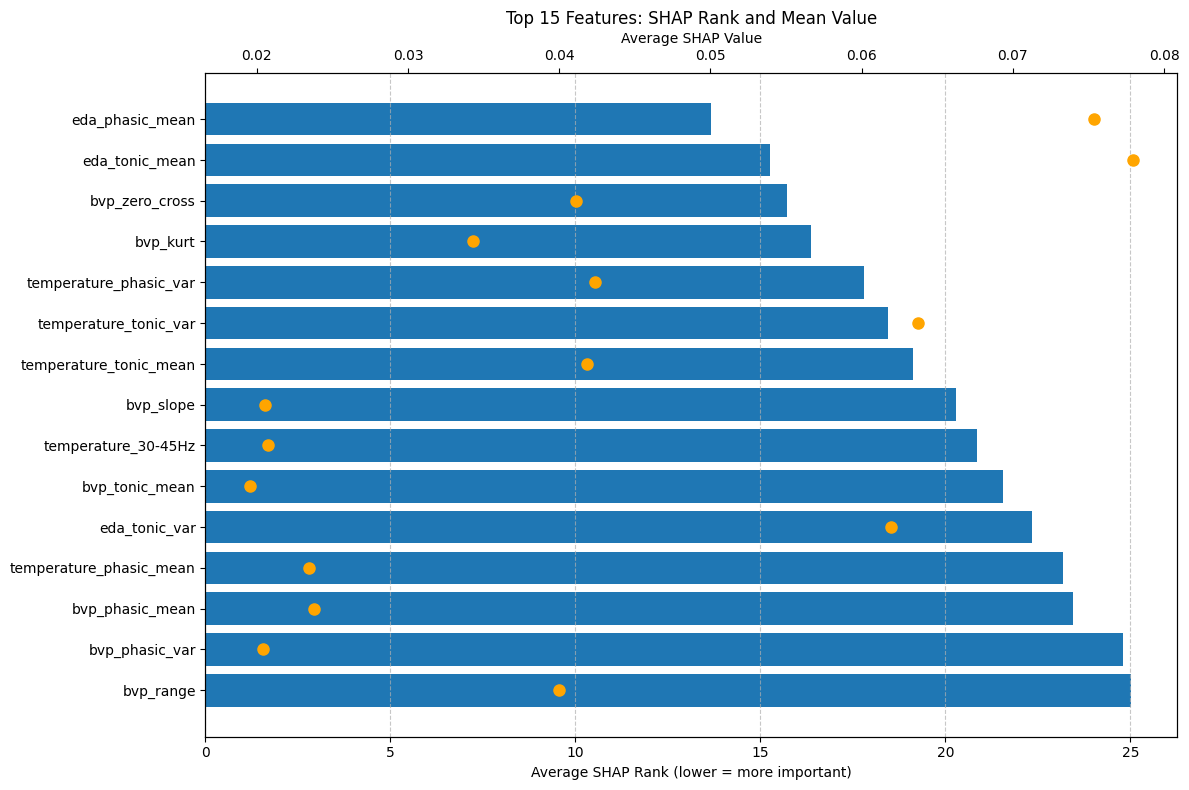

In [51]:
# Collect all features seen
all_feats = sorted({feat for feats in results['top_shap_feats'] for feat in feats})

# Build average rank DataFrame
def make_rank_map(feats):
    return {feat: feats.index(feat) + 1 if feat in feats else np.nan for feat in all_feats}

pos_df = pd.DataFrame(results['top_shap_feats'].apply(make_rank_map).tolist())
# Penalize absent features
K = results['top_shap_feats'].str.len().max()
pos_df = pos_df.fillna(K + 1)
avg_rank = pos_df.mean()

# Build average value DataFrame
def make_val_map(feats, vals):
    return {feat: vals[feats.index(feat)] if feat in feats else 0.0 for feat in all_feats}

val_df = pd.DataFrame([
    make_val_map(feats, vals)
    for feats, vals in zip(results['top_shap_feats'], results['top_shap_vals'])
])
avg_val = val_df.mean()

# Select top 15 by avg_rank
top15 = avg_rank.nsmallest(15).index

# Prepare data for plotting
ranks = avg_rank[top15]
values = avg_val[top15]

# Plot
fig, ax1 = plt.subplots(figsize=(12, 8))

y_pos = np.arange(len(top15))

# Bar for average rank
ax1.barh(y_pos, ranks, align='center')
ax1.set_yticks(y_pos)
ax1.set_yticklabels(top15)
ax1.invert_yaxis()
ax1.set_xlabel('Average SHAP Rank (lower = more important)')
ax1.set_title('Top 15 Features: SHAP Rank and Mean Value')

# Secondary axis for SHAP value
ax2 = ax1.twiny()
ax2.plot(values, y_pos, 'o', color='orange', markersize=8, label='Average SHAP Value')
ax2.set_xlabel('Average SHAP Value')

# Grid and layout
ax1.grid(axis='x', linestyle='--', alpha=0.7)
fig.tight_layout()
plt.show()

In [46]:
for feat in results['top_shap_feats'][0]:
    avg_rank = results['top_shap_feats'].apply(list.index, args=(feat,)).mean()
    print(f"Feature: {feat}, Average Rank: {avg_rank}")


Feature: temperature_tonic_var, Average Rank: 17.457875457875456
Feature: bvp_tonic_var, Average Rank: 26.043956043956044
Feature: temperature_tonic_mean, Average Rank: 18.135531135531135
Feature: bvp_phasic_mean, Average Rank: 22.44322344322344
Feature: eda_phasic_var, Average Rank: 27.38095238095238
Feature: eda_phasic_mean, Average Rank: 12.677655677655677
Feature: eda_tonic_var, Average Rank: 21.35164835164835
Feature: bvp_phasic_var, Average Rank: 23.7985347985348
Feature: eda_max, Average Rank: 35.24908424908425
Feature: bvp_tonic_mean, Average Rank: 20.553113553113555
Feature: eda_kurt, Average Rank: 35.02930402930403
Feature: eda_tonic_mean, Average Rank: 14.267399267399268
Feature: bvp_skew, Average Rank: 25.516483516483518
Feature: eda_range, Average Rank: 35.959706959706956
Feature: temperature_rms, Average Rank: 32.73992673992674
Feature: temperature_phasic_mean, Average Rank: 22.17948717948718
Feature: bvp_rms, Average Rank: 28.457875457875456
Feature: eda_var, Average Ran

In [77]:
results.columns

Index(['subject', 'tonic_cutoff', 'window_duration', 'step_size',
       'split_method', 'model', 'f1_macro', 'balanced_acc', 'top_shap_feats',
       'top_shap_vals'],
      dtype='object')

<Axes: xlabel='model', ylabel='balanced_acc'>

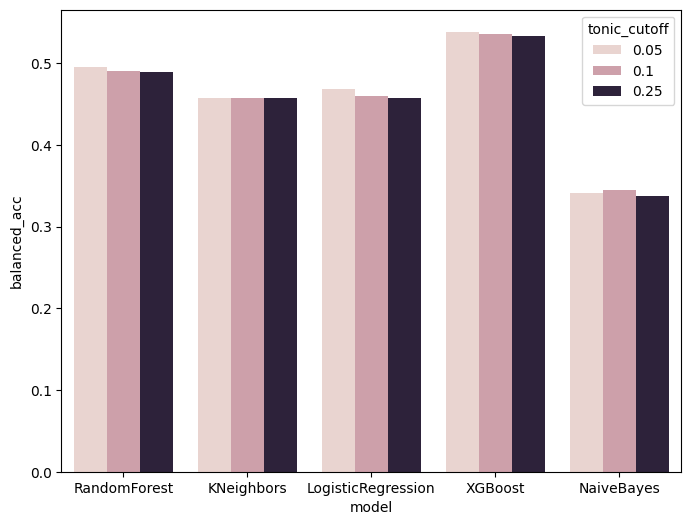

In [84]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.barplot(results, x='model', y='balanced_acc', hue='tonic_cutoff', errorbar=None, )

<Axes: xlabel='model', ylabel='balanced_acc'>

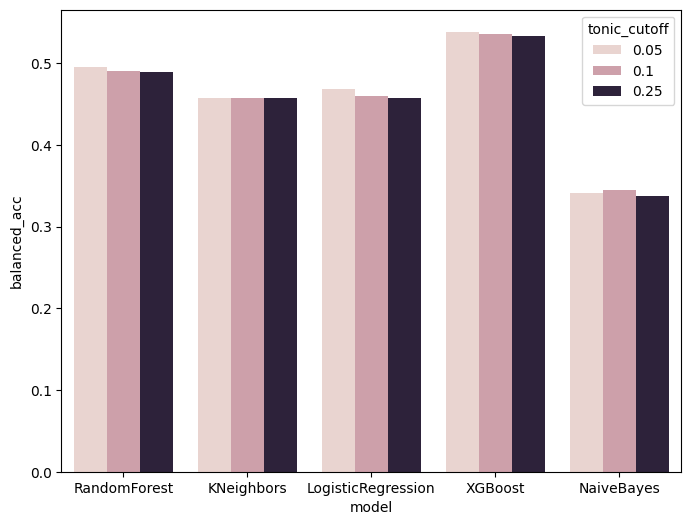

In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.barplot(results, x='model', y='balanced_acc', hue='tonic_cutoff', errorbar=None, )

In [ ]:

from sklearn.metrics import (
    f1_score,
    balanced_accuracy_score,
    classification_report
)

# 1) Instantiate and split your sliding-window pain dataset by 'Mode' groups
ds = BiomedicalPainDataset(
    signals_df=signals_df,
    pain_df=pain_df,
    timestamp_col='timestamp',
    window_duration=window_duration,
    step_size=step_size,
    signal_columns=['eda','bvp','temperature'],
    bandpass_freqs=(0.5,40),
    freq_bands=[(0.5,4),(4,8),(8,12),(12,30),(30,60)],
    resample_freq=100,
    include_tonic_phasic=True,
    tonic_cutoff= 0.05, # 20 Hz
)

#train_ds, test_ds = ds.split(test_size=0.2, split_by=['Mode']) # type: ignore
train_ds, test_ds = ds.split(test_size=0.2, stratify_by=['Mode']) # type: ignore
train_ds.apply_scaling('standard', fit=True)
test_ds.apply_scaling('standard', fit=False, scaler=train_ds.scaler)  # uses train_ds.scaler

train_ds.process_nan('interpolate', 'linear')

# 2) Helper to convert any BaseSlidingWindowDataset into X, Y NumPy arrays
def dataset_to_numpy(dataset: torch.utils.data.Dataset):
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    X_parts, Y_parts = [], []
    for Xb, Yb in loader:
        X_parts.append(Xb)
        Y_parts.append(Yb)
    X = torch.cat(X_parts, dim=0).numpy()
    Y = torch.cat(Y_parts, dim=0).flatten().numpy()
    return X, Y

X_train, y_train = dataset_to_numpy(train_ds)
X_test,  y_test  = dataset_to_numpy(test_ds)

# 3) (Optional) Balance your training set with a WeightedRandomSampler
class_counts = np.bincount(y_train.astype(int))
class_weights = 1.0 / class_counts
sample_weights = class_weights[y_train.astype(int)]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(y_train), replacement=False) # type: ignore

# Wrap balanced train set into a single batch
train_loader = DataLoader(
    TensorDataset(torch.tensor(X_train), torch.tensor(y_train)),
    sampler=sampler,
    batch_size=len(y_train)
)
X_train_bal, y_train_bal = next(iter(train_loader))
X_train_bal = X_train_bal.numpy();  y_train_bal = y_train_bal.numpy()

# 4) Define your modeling pipelines
def make_pipeline(estimator):
    return Pipeline([
        ('impute', SimpleImputer(strategy='mean')),
        ('scale',  StandardScaler()),
        ('clf',    estimator)
    ])

models = {
    'SVM':               make_pipeline(SVC(kernel='rbf', probability=True, random_state=42)),
    'RandomForest':      make_pipeline(RandomForestClassifier(n_estimators=100, random_state=42)),
    'GradientBoosting':  make_pipeline(GradientBoostingClassifier(random_state=42)),
    'KNeighbors':        make_pipeline(KNeighborsClassifier(n_neighbors=5)),
    'LogisticRegression':make_pipeline(LogisticRegression(max_iter=1000, random_state=42)),
    'XGBoost':           make_pipeline(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)),
}

# 5) Train & evaluate
for name, pipe in models.items():
    pipe.fit(X_train_bal, y_train_bal)
    y_pred = pipe.predict(X_test)
    print(f"\n=== {name} ===")
    print("F1 (macro):",            f1_score( y_test, y_pred, average='macro' ))
    print("Balanced Accuracy:",     balanced_accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred, digits=3))


In [66]:
X_train.max(), y_train.max(), X_test.max(), y_test.max()

(np.float32(nan), np.int64(2), np.float32(nan), np.int64(2))

In [56]:
np.unique(y_train), np.unique(y_test)

(array([0, 1, 2]), array([0, 1, 2]))

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, IsolationForest, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (
    f1_score,
    balanced_accuracy_score,
    classification_report
)

# --- 1) Collect all windows into numpy arrays once ---
dataset = BiomedicalPainDataset(
    signals_df=signals_df,
    pain_df=pain_df,
    timestamp_col='timestamp',
    window_duration=window_duration,
    step_size=step_size,
    signal_columns=['eda','bvp','temperature'],
    bandpass_freqs=(0.5,40),
    freq_bands=[(0.5,4),(4,8),(8,12),(12,30),(30,60)],
    resample_freq=100,
    include_tonic_phasic=True,
    tonic_cutoff= 1/20,  # 0.05 Hz
)

loader = DataLoader(dataset, batch_size=64, shuffle=False)
X_list, Y_list = [], []
for Xb, Yb in loader:
    X_list.append(Xb)
    Y_list.append(Yb)
X = torch.cat(X_list, dim=0).numpy()
Y = torch.cat(Y_list, dim=0).flatten().numpy()

# --- 2) Balance via weighted sampler (optional) ---
class_counts = np.bincount(Y)
class_weights = 1.0 / class_counts
sample_weights = class_weights[Y]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(Y), replacement=False) # type: ignore

# Wrap back to DataLoader if you really need batches, otherwise skip
balanced_loader = DataLoader(
    TensorDataset(torch.tensor(X), torch.tensor(Y)),
    batch_size=len(Y),
    sampler=sampler
)
for Xb, Yb in balanced_loader:
    X_bal, Y_bal = Xb.numpy(), Yb.numpy()
    break  # single epoch collects all

# --- 3) Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, Y_bal,  # type: ignore
    test_size=0.2,
    random_state=42,
    stratify=Y_bal # type: ignore
)

# --- 4) Define pipelines for each model ---
def make_pipeline(estimator):
    return Pipeline([
        ('impute', SimpleImputer(strategy='mean')),
        ('scale',  StandardScaler()),
        ('clf',    estimator)
    ])

models = {
    'SVM':             make_pipeline(SVC(kernel='rbf', probability=True, random_state=42)),
    'RandomForest':    make_pipeline(RandomForestClassifier(n_estimators=100, random_state=42)),
    'XGBoost':         make_pipeline(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)),
    'GradientBoosting':make_pipeline(GradientBoostingClassifier(random_state=42)),
    'KNeighbors':      make_pipeline(KNeighborsClassifier(n_neighbors=5)),
    'LogisticRegression': make_pipeline(LogisticRegression(max_iter=1000, random_state=42)),
}

# IsolationForest is for novelty detection; treat separately
iso_forest = IsolationForest(contamination='auto', random_state=42)

# --- 5) Train & Evaluate ---
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    print(f"\n-- {name} --")
    print("F1 (macro):", f1_score( y_test, y_pred, average='macro' ))
    print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred, digits=3))

# Outlier-based baseline
iso_forest.fit(X_train)
y_pred_if = (iso_forest.predict(X_test) == 1).astype(int)
# compare to majority class in y_test
maj_class = np.argmax(np.bincount(y_train))
y_test_binary = (y_test == maj_class).astype(int)
print("\n-- IsolationForest (novelty) --")
print("F1 (binary):", f1_score(y_test_binary, y_pred_if, average='binary'))
print("Balanced Accuracy:", balanced_accuracy_score(y_test_binary, y_pred_if))


In [38]:
X_train.min(), y_train.min(), X_test.min(), y_test.min()

(np.float32(nan), np.int64(0), np.float32(nan), np.int64(0))

In [ ]:
""" for p in range(1, 2):
    p=1
    signals_df = pd.read_csv(f'processed_signals/00{p}.csv')#[-16200:]
    pain_df = pd.read_csv(f'self_report/00{p}.csv')

    log_df = pd.read_csv(f'self_report/00{p}.csv')
    log_df['Timestamp'] = pd.to_datetime(log_df['Timestamp'])
    log_df = log_df.dropna(subset=['PainLevel'])
    log_df.sort_values('Timestamp', inplace=True)
    log_df['timestamp'] = log_df['Timestamp'].copy()
    first_mode_times = log_df.sort_values('timestamp').drop_duplicates('Mode')

    #first_mode_times['Mode'] = first_mode_times['PainLevel'].copy().astype(int) + 1

    #signals_df.drop('Unnamed: 0', axis=1, inplace=True)
    signals_df['Mode'] = np.nan
    signals_df['timestamp'] = pd.to_datetime(signals_df['timestamp']) 
    #signals_df['timestamp'] = pd.to_datetime(signals_df['timestamp'], unit='us') 
    #signals_df['timestamp'] = signals_df['timestamp'] - np.timedelta64(4, 'h')
    signals_df.sort_values('timestamp', inplace=True)

    for _, row in first_mode_times.iterrows():
        mode_time = row['timestamp']
        mode_value = row['Mode']
        
        # Find index in df2 with the closest timestamp
        closest_idx = (signals_df['timestamp'] - mode_time).abs().idxmin()
        signals_df.at[closest_idx, 'Mode'] = mode_value
        
    signals_df.at[0, 'Mode'] = 0
    signals_df['Mode'] = signals_df['Mode'].ffill()
    signals_df.to_csv(f'processed_signals/00{p}.csv', index=False) """

In [265]:
# Create dataset
dataset = BiomedicalPainDataset(
    signals_df=signals_df,
    pain_df=pain_df,
    window_duration=window_duration,       # t-second windows
    step_size=step_size,             # 1-second step
    signal_columns=[
                    #'accelerometer_x', 'accelerometer_y', 'accelerometer_z', 
                    #'gyroscope_x', 'gyroscope_y', 'gyroscope_z', 
                    'eda', 'bvp', 'temperature'],
    bandpass_freqs=(0.5, 40),  # 0.5-40 Hz bandpass
    freq_bands=[(0.5, 4), (4, 8), (8, 12), (12, 30), (30, 60)],  # Standard bands
    resample_freq=100,         # 100 Hz resampling
)
# Create DataLoader
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    #num_workers=4
)
# collect all data
x, y = [], []
for d in dataloader:
    x.append(d[0])
    y.append(d[1].to(torch.int64))
    
x = torch.concat(x, dim=0)
y = torch.concat(y, dim=0)
# create weighted sampler for balanced sampling
# Compute class counts and weights
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler

class_sample_count = torch.bincount(y.flatten())
weights = 1. / class_sample_count.float()
sample_weights = weights[y]

# Create sampler
sampler = WeightedRandomSampler(weights=sample_weights.view(-1), # type: ignore
                                 num_samples=len(y),
                                 replacement=False)

# Wrap into dataset and dataloader
dataset = TensorDataset(x, y)
dataloader = DataLoader(dataset, sampler=sampler, batch_size=32)
# recollect balanced data
x, y = [], []
for _ in range(1):
    for d in dataloader:
        x.append(d[0])
        y.append(d[1].to(torch.int64))
        
x = torch.concat(x, dim=0).numpy()
y = torch.concat(y, dim=0).numpy()

# Training loop
""" for features, pain_labels in dataloader:
    # features shape: (batch_size, n_features)
    # pain_labels shape: (batch_size,)
    # Your training code here """


' for features, pain_labels in dataloader:\n    # features shape: (batch_size, n_features)\n    # pain_labels shape: (batch_size,)\n    # Your training code here '

In [94]:
x_all, y_all = [], []

for subject in range (2,8):
    signals_df = pd.read_csv(f'processed_signals/00{p}.csv')#[-16200:]
    pain_df = pd.read_csv(f'self_report/00{p}.csv')
    # Hyper-parameters

    window_duration=1.0
    step_size=1.0


    # Create dataset
    dataset = BiomedicalPainDataset(
        signals_df=signals_df,
        pain_df=pain_df,
        window_duration=window_duration,       # t-second windows
        step_size=step_size,             # 1-second step
        signal_columns=[
                        #'accelerometer_x', 'accelerometer_y', 'accelerometer_z', 
                        #'gyroscope_x', 'gyroscope_y', 'gyroscope_z', 
                        'eda', 'bvp', 'temperature'],
        bandpass_freqs=(0.5, 40),  # 0.5-40 Hz bandpass
        freq_bands=[(0.5, 4), (4, 8), (8, 12), (12, 30), (30, 60)],  # Standard bands
        resample_freq=100,         # 100 Hz resampling
        apply_ica=False,            # Enable ICA
        ica_components=4           # Extract 4 ICA components
    )
    # Create DataLoader
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=32,
        shuffle=True,
        #num_workers=4
    )
    # collect all data
    x, y = [], []
    for d in dataloader:
        x.append(d[0])
        y.append(d[1].to(torch.int64))
        
    x = torch.concat(x, dim=0)
    y = torch.concat(y, dim=0)
    # create weighted sampler for balanced sampling
    # Compute class counts and weights
    from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler

    class_sample_count = torch.bincount(y)
    weights = 1. / class_sample_count.float()
    sample_weights = weights[y]

    # Create sampler
    sampler = WeightedRandomSampler(weights=sample_weights,
                                    num_samples=len(y),
                                    replacement=False)

    # Wrap into dataset and dataloader
    dataset = TensorDataset(x, y)
    dataloader = DataLoader(dataset, sampler=sampler, batch_size=32)
    # recollect balanced data
    
    for _ in range(1):
        for d in dataloader:
            x_all.append(d[0])
            y_all.append(d[1].to(torch.int64))
            
x_all = torch.concat(x_all, dim=0).numpy()
y_all = torch.concat(y_all, dim=0).numpy()

In [266]:
# train models
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Train-test split
#x,y=x_all,y_all
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Standardize features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

models = {
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    'IsolationForest': IsolationForest(contamination='auto', random_state=42)  # Only for novelty detection
}

# Train and evaluate models
for name, model in models.items():
    if name == 'IsolationForest':
        model.fit(x_train)
        # Predict: normal = 1, outlier = -1
        y_pred = model.predict(x_test)
        y_pred = (y_pred == 1).astype(int)  # Binary classification (normal = 1)
        y_test_binary = (y_test == y_test[0]).astype(int)  # Compare to one class
        print(f"{name} (vs class {y_test[0]})")
        print("  F1 Score:", f1_score(y_test_binary, y_pred, average='binary'))
        print("  Accuracy:", balanced_accuracy_score(y_test_binary, y_pred))
    else:
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        print(f"Subject {subject}: window size={window_duration} seconds; step size={step_size} seconds")
        print(f"{name}")
        print("  F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))
        print("  Accuracy:", balanced_accuracy_score(y_test, y_pred))
        print("  Class-wise report:\n", classification_report(y_test, y_pred, digits=3))
        print()

ValueError: Input X contains NaN.
SVC does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [74]:
(y_test==1).sum()

np.int64(1512)

In [ ]:
# Perform ANOVA
f_values, p_values, significant = dataset.perform_anova(max_samples_per_class=500)

In [40]:
my_func = np.vectorize(lambda x: x if x ==0 else 1 if 1<=x<=5 else 2)

# Data processing

## 1. Sliding window

- window size
- window overlap

## 2. Raw data

### 1. synchronization/interpolation
- Forward fill
- Linear interpolation
- B-spline

## 3. Train-test split

- random splitting (might have information leak)
- split by pain stimulation mode
- spit by subject (leave one subject out)


# Data analysis

## 1. Statistical analysis

## 2. Machine Learning Models